#### CITS5508 Assignment 2
* _File          : assignment2.ipynb_
* _Contact       : 22056151@student.uwa.edu.au_
* _Author        : Suning (Juliet) Li_
<br><br>
* _Editor        : Visual Studio Code 1.77.0_
* _Python Version: 3.10_
* _Version       : 1.0_
<br><br>
* _License       : (C)Copyright Juliet_Li_2023_
* _Description   : This is the python notebook for CITS5508 assignment 2._
* _ModifyTime    : 02/05/2023_

# Section 1: Breast cancer wisconsin (diagnostic) dataset <br>
The Breast Cancer dataset is a common choice for machine learning classification tasks. It contains 569 digitized breast mass images with 30 numeric features describing cell nuclei characteristics, including radius, texture, and symmetry. The dataset's purpose is to classify samples as malignant or benign based on these features. Each image has an ID number and a diagnosis attribute of M for malignant or B for benign. Ten real-valued features are computed for each cell nucleus, and the mean, standard error, and "worst" of these features were calculated for each image, resulting in 30 features.

### Part 1: Load and Prepare the data
* Load the data into feature and target space
* Investigate the data with some visualiations (check for feature correlation etc)
* write a data pipeline (function) to prepare and clean the data
* As we are training decision tree in this section, no feature scaling is needed

In [1]:
#load the data
from sklearn.datasets import load_breast_cancer

breast_cancer_data = load_breast_cancer()

# features space
arr_x = breast_cancer_data.data

# target values
arr_y = breast_cancer_data.target

# feature names
feature_names = breast_cancer_data.feature_names

# target names
target_names = breast_cancer_data.target_names

In [2]:
#investigate and make sure the feature matrix is 569*30, and the target space is 569
print('The shape of the feature space is', arr_x.shape)
print('The shape of the target space is', arr_y.shape)

The shape of the feature space is (569, 30)
The shape of the target space is (569,)


In [3]:
# Load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#Create dataframe that integrates feature space
df_feature = pd.DataFrame(arr_x, columns=feature_names)

# Generate correlation matrix for all features
correlation_matrix = df_feature[feature_names].corr()

In [5]:
df_feature.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0                 0.07871  ...         25.38          17.33           184.60   
1                 0.05667  ...         24.99          23.41           158.80   
2                 0.05999  ...         23.57          25.53           152.50   
3                 0.09744  ...         14.91          26.50            98.87   
4                 0.05883  ...         22.54          16.67           152.20   

   worst area  worst smoothness  worst compactness  worst concavity  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   worst concave points  worst symmetry  worst fractal dimension  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 30 columns]

As can be seen, all features are numeric. There is no text features that needs to be converted. In addition, as we are first training decision tree in this section. Feature scaling is not really needed. 

Feature scaling is generally not required for decision tree-based models, including Decision Trees, Random Forests, and Gradient Boosted Trees. These models are non-parametric, meaning they do not make assumptions about the underlying data distribution. Instead, they build a hierarchical structure by iteratively splitting the data based on feature values to create a tree-like arrangement.

Since these models depend on the inherent organization of the data and utilize categorical decisions rather than relative distances between data points, scaling the features typically does not impact their performance. As a result, feature scaling is often unnecessary when working with decision tree-based models.

In [6]:
# To see the total number of missing values in the entire DataFrame
total_missing_values = df_feature.isna().sum().sum()
print(f"\nTotal missing values in DataFrame: {total_missing_values}")


Total missing values in DataFrame: 0


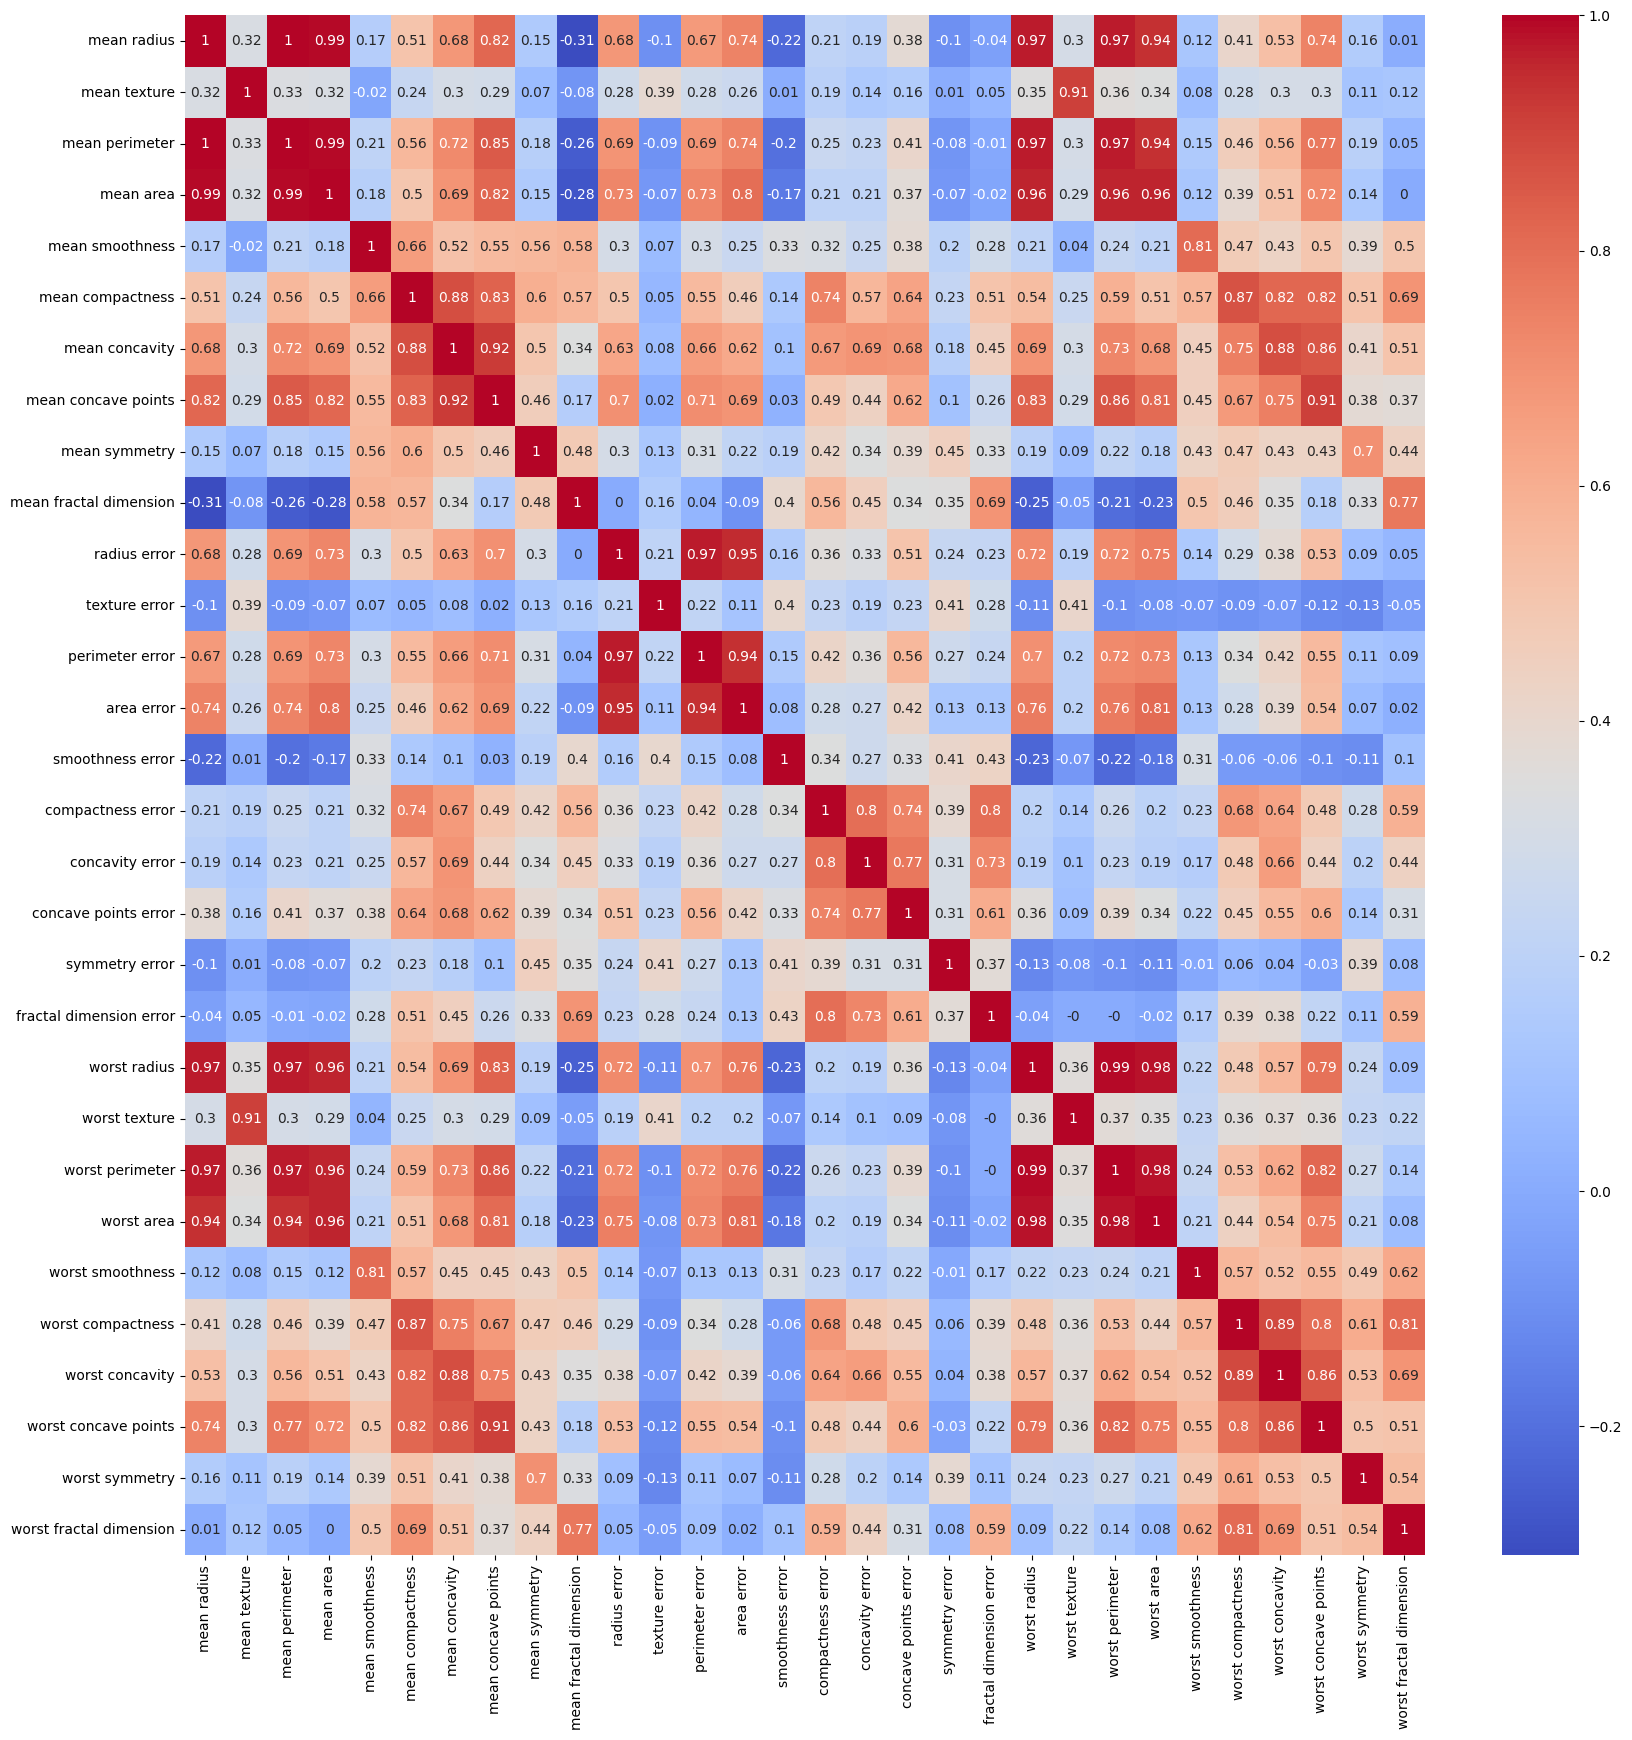

In [7]:
# Plot the heatmap of correlation matrix for all features
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix.round(2), annot=True, cmap='coolwarm')
plt.show()

The above is the correlation matric for all features in the feature space. As can be seen, some of the features are highly correlated with each other, having higher than 0.9 correlation (or lower than -0.9) for some of the features. This will cause the following issues:
* __Multicollinearity__: For two highly correlated features, it is hard for the model to determine individual contribution of each feature to the target. It is especially troublesome with linear regression models and models that rely on the covariance matrix, such as Principal Component Analysis (PCA), causing the estimated parameters to be unreliable.
* __Overfitting__: Model may rely too heavily on a small number of correlated features to make predictions, leading to overfitting problems, and poor generalization. 
* __Interpretability__: It becomes difficult to interpret the importance of individual features in the context of the model, limiting the interpretability of the model and feature contribution
* __Redundancy__: Highly correlated features provides little additional information for the model, adding unnecessary complexity.

We will be dropping the highly correlated features below using a function.

In [117]:
# define a function to drop highly correlated features
def drop_corr_features(correlation_threshold,correlation_matrix,df_feature):
    
    # Create a set for the features to be dropped
    features_to_drop = set()

    # Loop through the correlation matrix and identify the features that are highly correlated and are to be dropped
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) >= correlation_threshold:
                colname = correlation_matrix.columns[i]
                
                features_to_drop.add(colname)
                # #Print the highly correlated features 
                # print(colname, ',', correlation_matrix.index[j], ':', correlation_matrix.iloc[i, j])
    if len(features_to_drop) > 0:
        # Drop the features from the original dataframe
        df_feature_dropped = df_feature.drop(features_to_drop, axis=1)
    else:
        df_feature_dropped = df_feature

    # print the features that should be dropped as they are highly correlated with other features
    print(len(features_to_drop), 'features is dropped:',features_to_drop)

    return df_feature_dropped

In [118]:
# drop features that has higher correlation than 0.9 or lower than -0.9
df_feature_dropped = drop_corr_features(0.9,correlation_matrix,df_feature)

10 features is dropped: {'worst radius', 'area error', 'worst area', 'perimeter error', 'mean area', 'worst texture', 'mean perimeter', 'mean concave points', 'worst perimeter', 'worst concave points'}


In [119]:
# Update the feature space
arr_x_drpped = df_feature_dropped.values

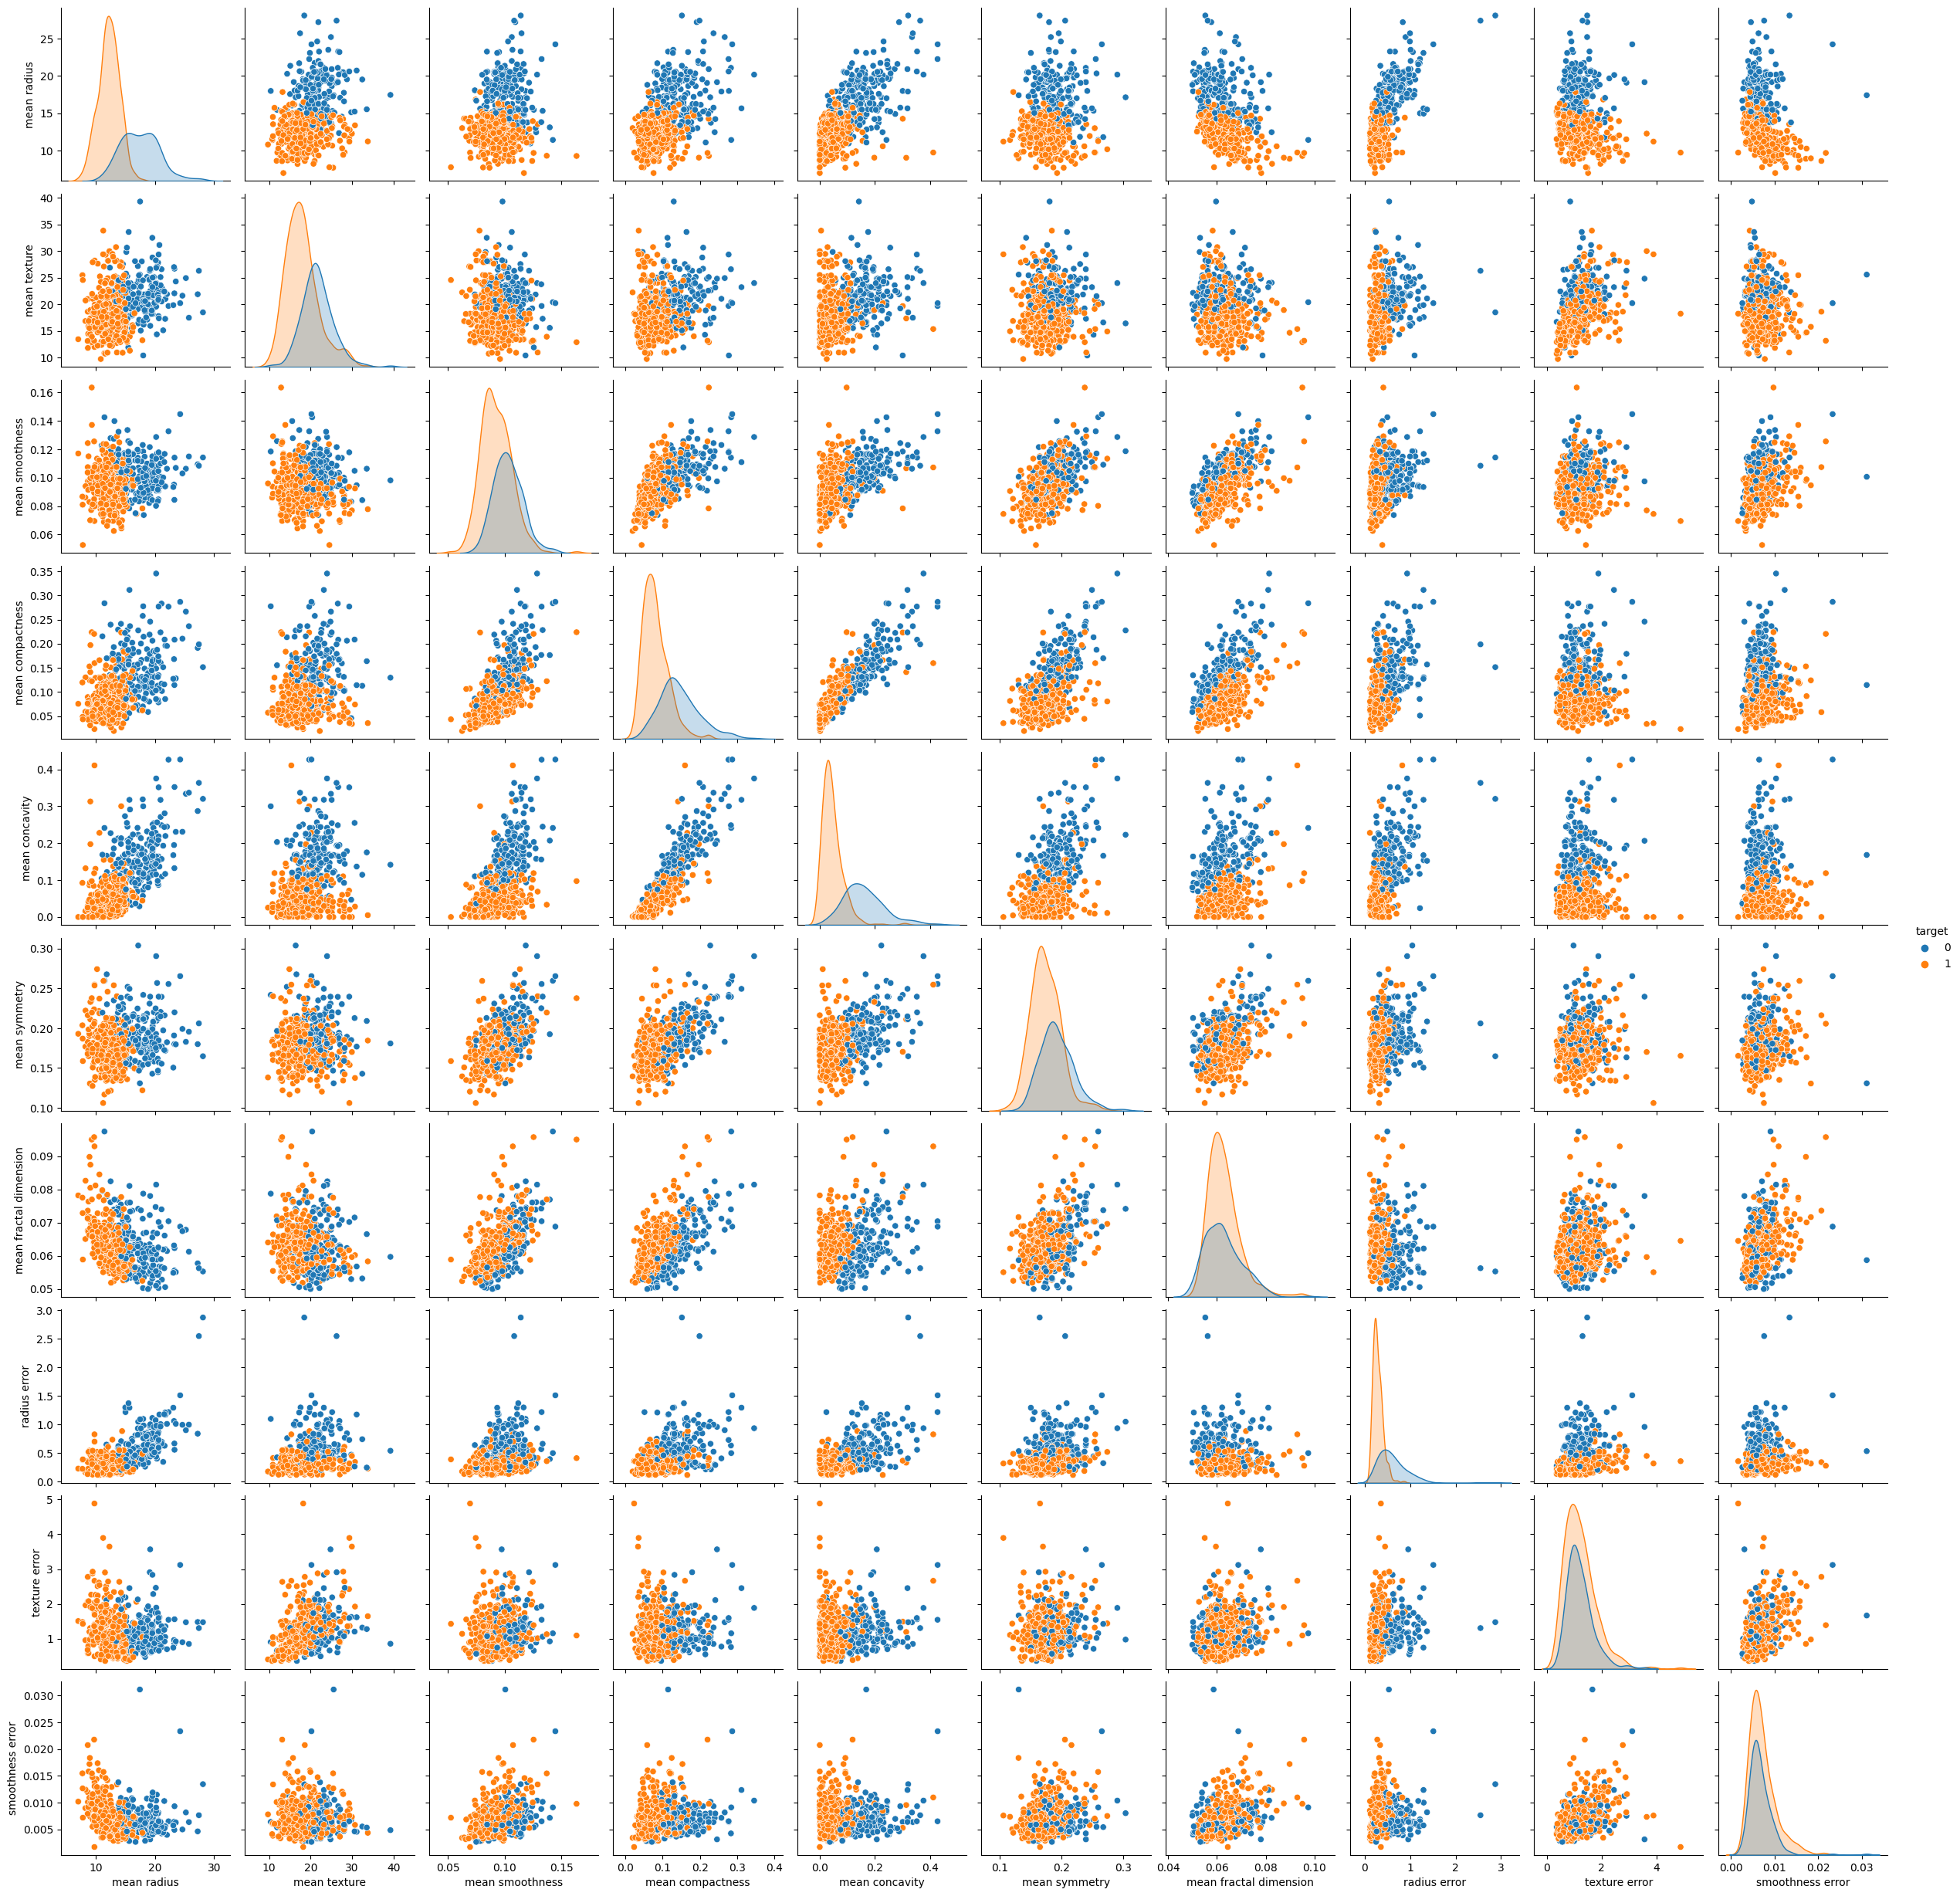

In [120]:
# select the first 10 features to plot, to see the separation of the feature space
li_selected = df_feature_dropped.columns[:10]
df_full = df_feature_dropped.copy()
df_full['target'] = arr_y

# Plot the relationship between features and target
# plt.figure(figsize=(20,20))
sns.pairplot(df_full, vars=li_selected, hue='target')
plt.show()

# As can be seen from below, the feature space is relatively separated.

In reference to the plot above:
* The plot is plotting each feature pair for the first 10 features in the dropped feature space, coloured by the target value. 
* As can be seen, for a lot of the feature pairs, the feature space is relatively separated. It is observed from the graph as the two-colour scatters are relatively separated from each other. 
* Relatively separatable feature space indicates the task will in general be performed well. 
* Nonetheless, as can be seen, some feature pair space is still non-separatable. E.g. texture_error and smoothness error.

In [12]:
# Split the data into training and test sets (85/15)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(arr_x_drpped, arr_y, test_size=0.15, random_state=123)

# As we are first training decision tree models, typical decision tree does not require feature scaling. Feature scaling will not be performed here. 

### Part 2: Training Decision Tree Models and Discuss Results
* with default values for all the hyperparameters
* Only setting the hyperparameter max depth=3
* only setting the hyperparameter min samples split=5
* only setting the hyperparameter min samples leaf=5
* Using 3-fold cross-validation and grid-search to find the best combination of these hyperparameters (max depth, min samples split and min samples leaf).

In [13]:
# First, train the decision tree model using default hyperparameters
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# Train the decision tree classifier
dt_clf = DecisionTreeClassifier(random_state=123)
dt_clf.fit(X_train, y_train)

# Perform predictions on the training set and the test set
y_train_pred = dt_clf.predict(X_train)
y_test_pred = dt_clf.predict(X_test)

# Compare the accuracy scores for the two sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
tree_depth = dt_clf.get_depth()

print("Training set accuracy:", train_accuracy)
print("Test set accuracy:", test_accuracy)
print("The depth of the tree is:", tree_depth)

Training set accuracy: 1.0
Test set accuracy: 0.8953488372093024
The depth of the tree is: 7


The decision tree trained using all default hyperparameters:
* have depth of 7
* have complete accuracy (100%) on the training set. 
* have 89.5% accuracy on the testing set. 
* There is a big gap between accuracy on training and testing set.
* The complete accuracy on the training set indicates that the model is definitely overfitting, having unacceptably high variance. 
* Due to the overfitting, the accuracy for the test set is not as well as the training set, having a big gap between the performance on the training and test set.
* The default hhyperparamters of the DecisionTreeClassifier is explained in the next markdown. As can be seen, using the default hyperparameters, the decision tree will grow uncontrolably to fit the training set to the best it can (in this case 100%). A decision tree with all default hyperparameter will inevitably have overfitting issues.

The __DecisionTreeClassifier__ has the below hyperparameters and default values:
* __criterion__: The criterion parameter in decision tree-based models defines the function used to measure the quality of a split at each node of the tree. The supported criteria include "gini" for Gini impurity, "entropy" for Shannon's entropy, and "log_loss" for logarithmic loss. By default, the "gini" criterion is used. Gini impurity measures the degree to which samples in a node are mixed, while Shannon's entropy and logarithmic loss measure the information gain resulting from a split. These functions help determine the optimal decision points in the tree, which ultimately impacts the model's performance and interpretability. The choice of criterion can influence the structure of the resulting tree and should be selected based on the specific problem and dataset.
* __splitter__: The "splitter" parameter in decision tree models determines the strategy used to select the optimal split at each node during the tree construction process. Two strategies are available: "best" and "random". The default "best" strategy selects the split that provides the highest improvement in impurity, ensuring the most informative split at each node. The "random" strategy, on the other hand, chooses the best split from a random subset of candidate splits. This approach introduces randomness into the tree construction process, potentially increasing diversity in ensemble methods or mitigating overfitting in some cases.
* __max_depth__: The max_depth parameter in decision trees controls the maximum depth of the tree. By default, it is set to None, which means that the tree will continue to expand until all leaves are pure or have fewer samples than the specified __min_samples_split__.
* __min_samples_split__: The min_samples_split hyperparameter in a decision tree-based model determines the minimum number of samples required to split an internal node. This parameter can be an integer or a float. If an integer is provided, it represents the minimum number of samples directly. If a float is provided, it represents a fraction of the total number of samples in the dataset, and the minimum number of samples for each split is calculated as the ceiling of the product of the fraction and the total number of samples (ceil(min_samples_split * n_samples)). By adjusting this hyperparameter, we can control the granularity of the tree and prevent overfitting by not allowing nodes to split if they have too few samples.
* __min_samples_leaf__: The min_samples_leaf parameter in a decision tree model represents the minimum number of samples required to form a leaf node. It helps prevent overfitting by enforcing a minimum threshold on the number of samples in each leaf node. If set as an integer, it is the minimum number of samples required; if set as a float, it is treated as a fraction of the total number of samples. This parameter can smooth the model, especially in regression tasks, by avoiding overfitting to small, noisy subsets of the data.
* __min_weight_fraction_leaf__: The min_weight_fraction_leaf parameter, with a default value of 0.0, represents the minimum weighted fraction of the total sample weights needed for a leaf node in a decision tree. When no sample weights are provided, all samples have equal weight. Adjusting this parameter helps control the minimum size of leaf nodes and can prevent overfitting by ensuring that each leaf node contains a certain fraction of the overall sample weights.
* __max_features__: The max_features parameter in a machine learning model determines the number of features considered when searching for the best split. It can be an integer, float, or one of the strings "auto", "sqrt", "log2", or None. An integer value considers that many features at each split. A float value treats it as a fraction, considering int(max_features * n_features_in_) features. "auto" or "sqrt" sets max_features to the square root of the number of features, while "log2" sets it to the base-2 logarithm of the number of features. If None, all features are considered at each split -- default.
* __random_state__: Controls the randomness of the model, default is None:
* __max_leaf_nodes__: The max_leaf_nodes parameter controls the maximum number of leaf nodes a tree can have during the growth process. The tree grows in a best-first fashion, prioritizing nodes that provide the most significant reduction in impurity. If set to None (default), there is no limit to the number of leaf nodes, potentially leading to more complex trees.
* __min_impurity_decreasefloat__: A node will be split if this split induces a decrease of the impurity greater than or equal to this value. Default is 0.0
* __class_weight__: Default is None. The class_weight parameter allows you to assign different weights to classes in classification problems, helping to balance imbalanced datasets. If set to None, all classes have equal weight. For multi-output problems, a list of dictionaries can be provided, with weights specified for each class in each output column. The "balanced" mode automatically adjusts weights based on class frequencies in the input data, helping to mitigate the effects of imbalanced classes. If sample_weight is provided, it will be multiplied with the class weights during model fitting.
* __ccp_alpha__: The ccp_alpha parameter is a non-negative float used for Minimal Cost-Complexity Pruning in decision trees. It controls the trade-off between model complexity and performance, with larger values leading to more pruning. By default, no pruning is performed (ccp_alpha=0.0). The subtree with the largest cost complexity smaller than ccp_alpha is selected, simplifying the tree while minimizing the impact on predictive performance.

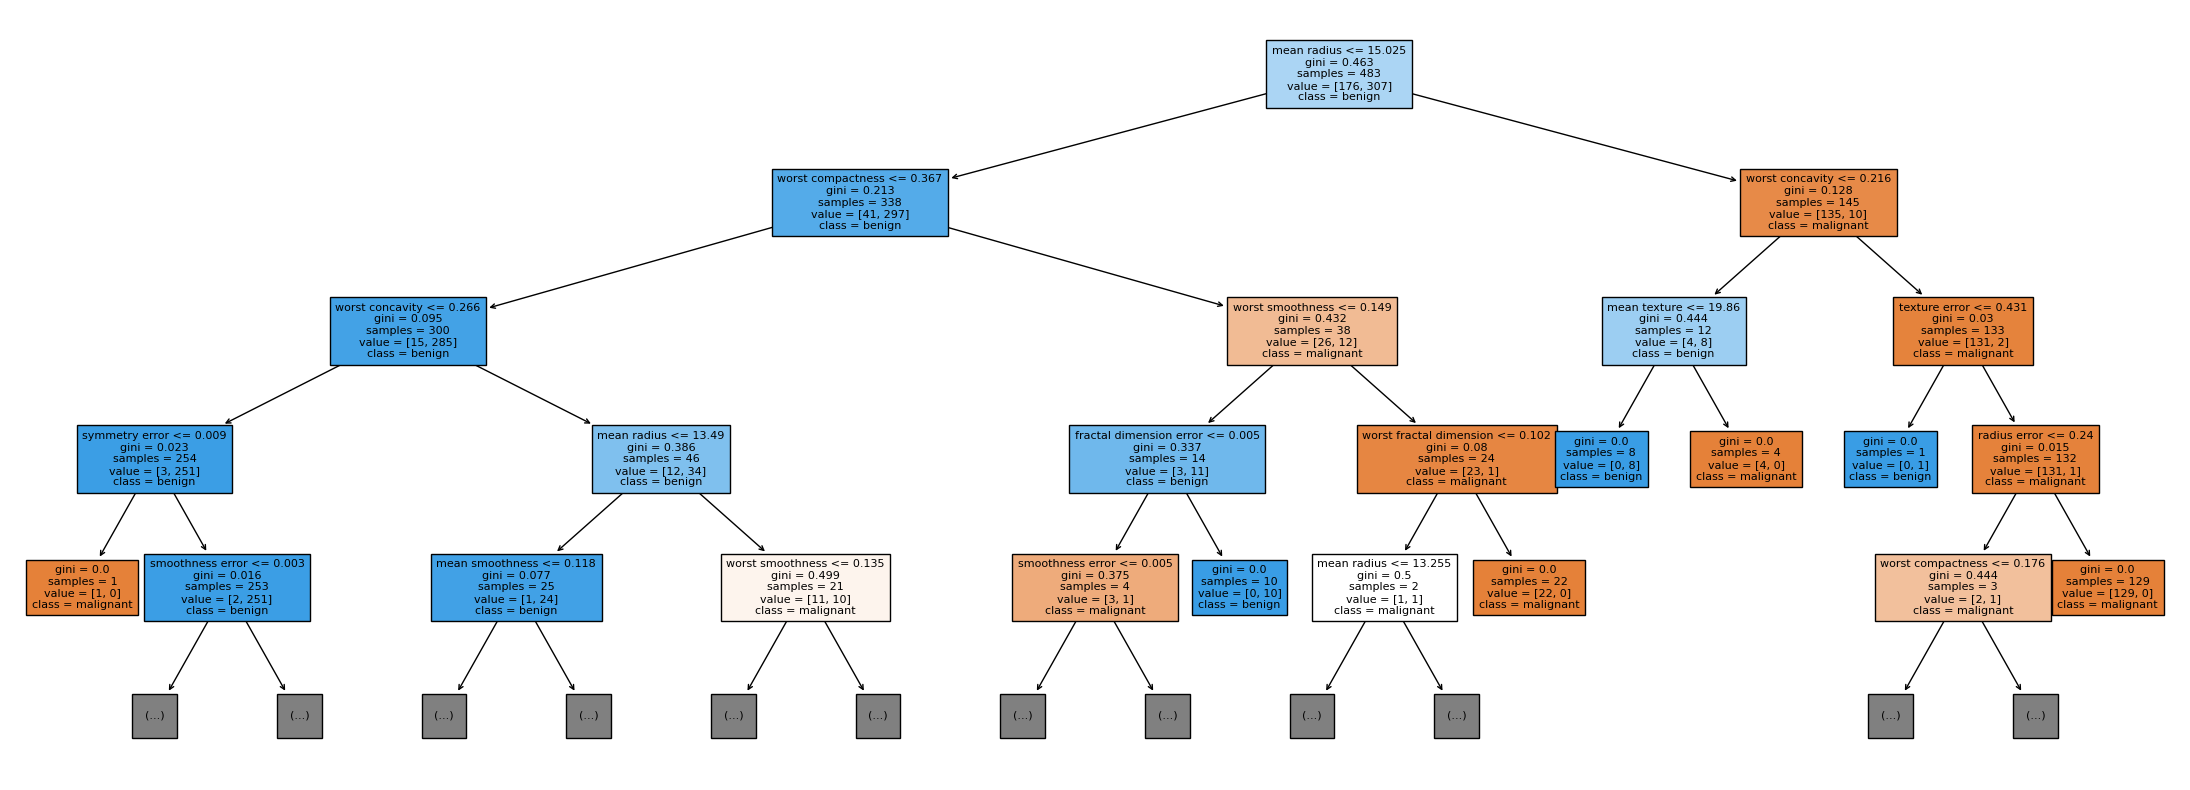

In [14]:
# Display the decision tree built from the training process (limited to max_depth=3)
plt.figure(figsize=(28, 10))
plot_tree(dt_clf, max_depth=4, filled=True, feature_names=df_feature_dropped.columns, class_names=target_names,fontsize=8)
plt.show()

In reference to the graph above:

There are following elements in the plot:
* __Root node__: The highest node in the tree, from which all other nodes branch out.
* __Internal nodes__: Nodes that have both parent and child nodes. These nodes represent a decision based on a feature value.
* __Leaf nodes__: The terminal nodes of the tree, where no more decisions are made. These nodes represent the final predicted outcome or class label.

* __Decision rule__: Each internal node displays a decision criterion based on a feature and a threshold value. This criterion is employed to divide the dataset into subsets based on the specified feature and threshold.

* __Gini impurity__: A measure of node impurity, displayed within each node, is the Gini impurity. This value ranges between 0 (completely homogeneous) and 1 (completely heterogeneous), with lower values indicating a more successful split. The Gini impurity is employed in the classification decision tree algorithm (CART) to evaluate the effectiveness of splits.

* __Samples__: The quantity of samples that arrive at each node, including both internal and leaf nodes.

* __Value distribution__: The spread of class labels or target values across the samples that reach each node. In classification contexts, the node displays the number of samples belonging to each class. In regression situations, the node showcases the mean of the target values present in that node.

* __Class__: For classification trees, the most common class label in each node is shown. This label is used to make predictions when a sample reaches that node.

__Observtions__:
* The decision tree built from default hyperparameters is plotted above, using the plot_tree function.
* The depth of the three is 7, already a small indicator of overfitting. Here 4 depth is plotted.
* As can be seen, there is some leaf notes with very little samples. E.g. the leaf note to the very left with only one sample, indicating overfitting. 
* Complex splits is observed in the decision tree, trying to separate the data to maximum, indicating overfitting as well. 
* Gini reduction for some of the internal nodes is not big, indicating the further split is only to trying to maximally fix data without using deterministic features.

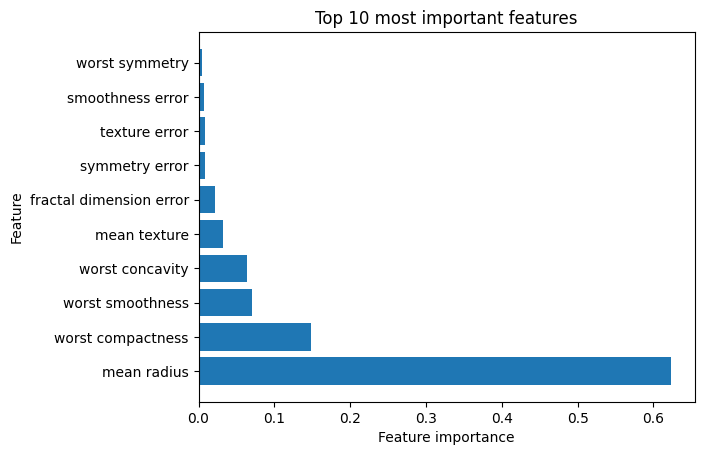

In [152]:
# Checking the feature importance for the first decision tree
import numpy as np
importances = dt_clf.feature_importances_

# # Sort the features by importance score in descending order
# indices = np.argsort(importances)[::-1]

# Sort the feature importances in descending order and get the indices of the top 10
sorted_indices = np.argsort(importances)[::-1][:10]

# Create a horizontal bar plot of the top 10 features and their importances
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), df_feature_dropped.columns[sorted_indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Top 10 most important features')
plt.show()


In reference to the above cell:
* feature importance of the first decision tree is calculated.
* The highest three features are mean radius, worst compactness, and worst smoothness, having high deterministic relationship with the tumour type
* We would like to compare this with the other models.

In [15]:
# Train a second decision tree classifier with only max depth=3 hyperparameter
dt_clf_depth3 = DecisionTreeClassifier(max_depth=3, random_state=123)
dt_clf_depth3.fit(X_train, y_train)

# Perform predictions on the training set and the test set
y_train_pred_depth3 = dt_clf_depth3.predict(X_train)
y_test_pred_depth3 = dt_clf_depth3.predict(X_test)

# Compare the accuracy scores for the two sets
train_accuracy_depth3 = accuracy_score(y_train, y_train_pred_depth3)
test_accuracy_depth3 = accuracy_score(y_test, y_test_pred_depth3)
tree_depth_depth3 = dt_clf_depth3.get_depth()

print("Training set accuracy:", train_accuracy_depth3)
print("Test set accuracy:", test_accuracy_depth3)
print("The depth of the tree is:", tree_depth_depth3)

Training set accuracy: 0.9585921325051759
Test set accuracy: 0.8837209302325582
The depth of the tree is: 3


In referece to the second decision tree above:
* only hyperparameter max depth=3 is set, limiting the maximum depth of the tree to be three.
* The accuracy of the training set is 95.9%.
* The accuracy of the test set is 88.4%.
* Comparing with the previous decision model using all default hyperparameters, the training set performance is no longer 100%. And the test set accuracy is slightly lower as well.
* Comparing with the previous model, we can see that the next 4 depths in the previous three is only improving the result by about 4%.
* However, there is still a relatively big gap between accuracy of the training and test set, indicating issues with overfitting still exist. 
* If cross-validation is tried here, we will see the generalisation capability of the model is still not good. 

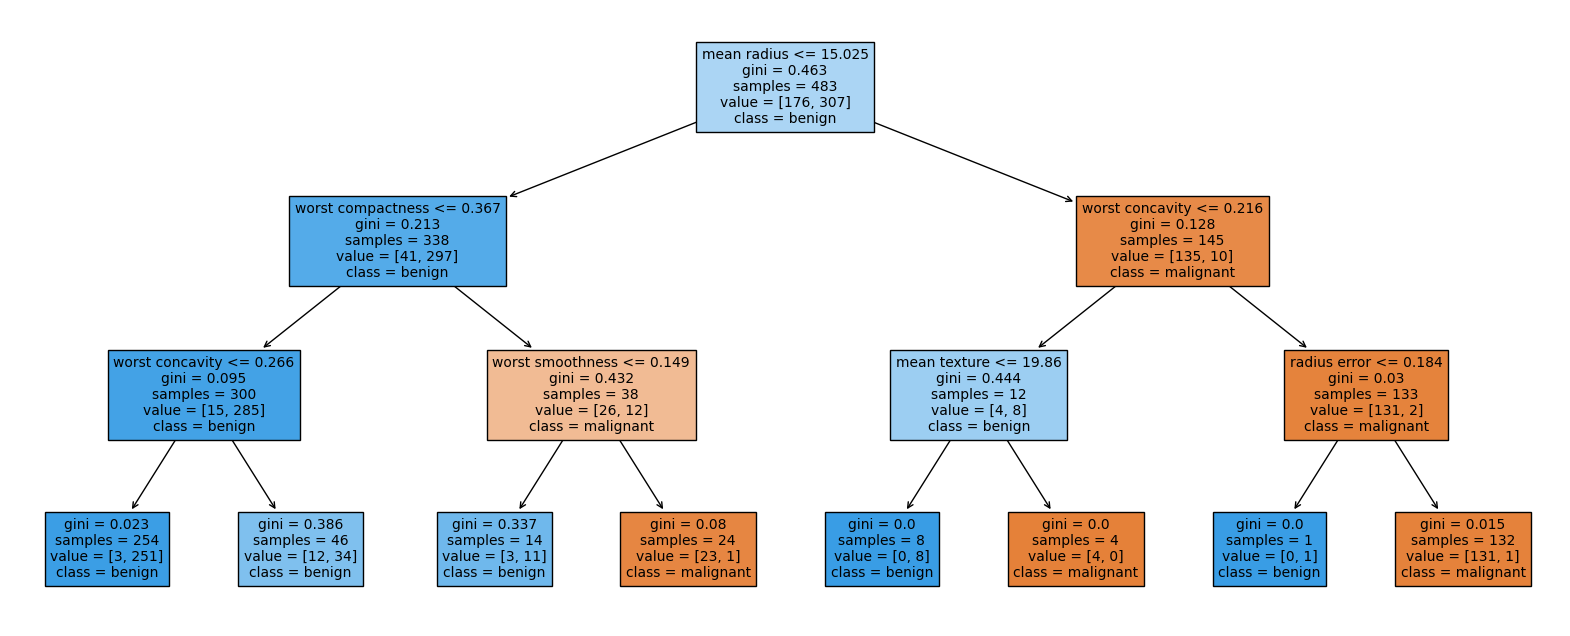

In [16]:
# Display the decision tree built from the training process (limited to max_depth=3)
plt.figure(figsize=(20, 8))
plot_tree(dt_clf_depth3, max_depth=3, filled=True, feature_names=df_feature_dropped.columns, class_names=target_names,fontsize=10)
plt.show()

In reference to the cell above:
* The decision tree built from default hyperparameters is plotted above, using the plot_tree function.
* All three depth is plotted.
* As can be seen, there is some leaf notes still have relatively similar samples for each class (high gini values). E.g. Second leaf note from the left [12,34].
* The model is trying to fit the training set the best, therefore still having overfitting issue with not ideal generalisation capacity.

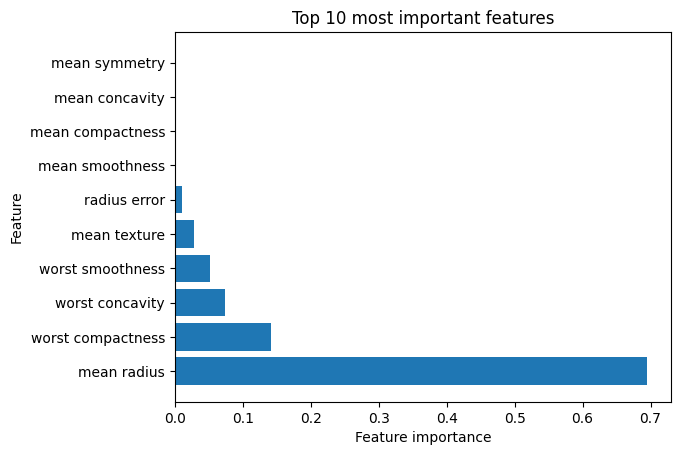

In [151]:
# Checking the feature importance for the first decision tree
import numpy as np
importances = dt_clf_depth3.feature_importances_

# # Sort the features by importance score in descending order
# indices = np.argsort(importances)[::-1]

# Sort the feature importances in descending order and get the indices of the top 10
sorted_indices = np.argsort(importances)[::-1][:10]

# Create a horizontal bar plot of the top 10 features and their importances
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), df_feature_dropped.columns[sorted_indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Top 10 most important features')
plt.show()


In reference to the above cell:
* feature importance of the second decision tree is calculated.
* The highest three features are mean radius, worst compactness, and worst concavity, having high deterministic relationship with the tumour type.
* The highest two features are the same as before, the third highest feature was the fourth highest feature before. So the two models are still relavant with each other.

In [17]:
# Train a third decision tree classifier with min_samples_split=5
dt_clf_sampleSplit5 = DecisionTreeClassifier(min_samples_split=5, random_state=123)
dt_clf_sampleSplit5.fit(X_train, y_train)

# Perform predictions on the training set and the test set
y_train_pred_sampleSplit5 = dt_clf_sampleSplit5.predict(X_train)
y_test_pred_sampleSplit5 = dt_clf_sampleSplit5.predict(X_test)

# Compare the accuracy scores for the two sets
train_accuracy_sampleSplit5 = accuracy_score(y_train, y_train_pred_sampleSplit5)
test_accuracy_sampleSplit5 = accuracy_score(y_test, y_test_pred_sampleSplit5)
tree_depth_sampleSplit5 = dt_clf_sampleSplit5.get_depth()

print("Training set accuracy:", train_accuracy_sampleSplit5)
print("Test set accuracy:", test_accuracy_sampleSplit5)
print("The depth of the tree is:", tree_depth_sampleSplit5)

Training set accuracy: 0.9917184265010351
Test set accuracy: 0.9069767441860465
The depth of the tree is: 7


In referece to the third decision tree above:
* only hyperparameter min_samples_split=5 is set, limiting the when & how the decision tree can be further split.
* The accuracy of the training set is 99.2%.
* The accuracy of the test set is 90.7%.
* Comparing with the previous decision models, the training set performance is wosre. but the test set accuracy is better.
* The depth of the tree is 7. It means there are some very complex splits happening here, overfitting the training data.
* There is a not small gap between the accuracy of training and test set.
* If we try cross-validation, we will see that this model still has not ideal generalisation capability. 

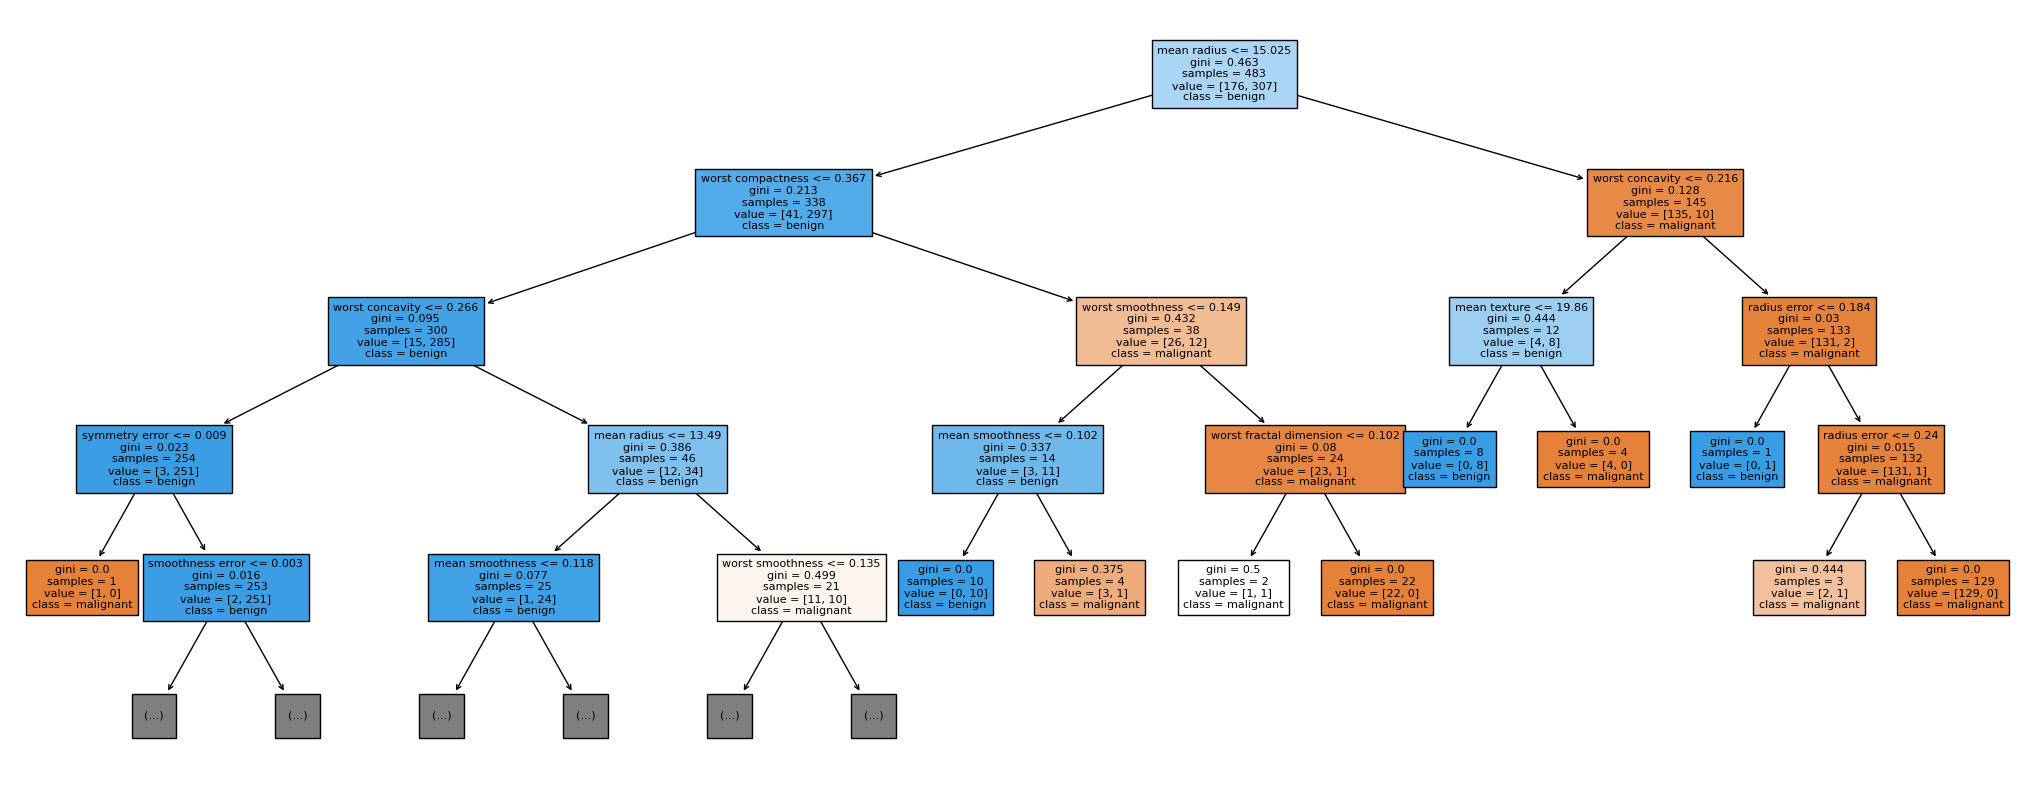

In [18]:
# Display the decision tree built from the training process (limited to max_depth=3)
plt.figure(figsize=(26, 10))
plot_tree(dt_clf_sampleSplit5, max_depth=4, filled=True, feature_names=df_feature_dropped.columns, class_names=target_names,fontsize=8)
plt.show()

In reference to the plot above:
* plot_tree function is used here, plotting the first 4 depths of the tree.
* Looking at the gini value at different depth, we can see that some of the gini values are still quite high at 4th depth.
* The model will have to generate to the 7th depth to have the best accuracy on the training set, overfitting the feature space.
* The criteria rule of the first splits to the 4th depth is very similar to the previous two models.

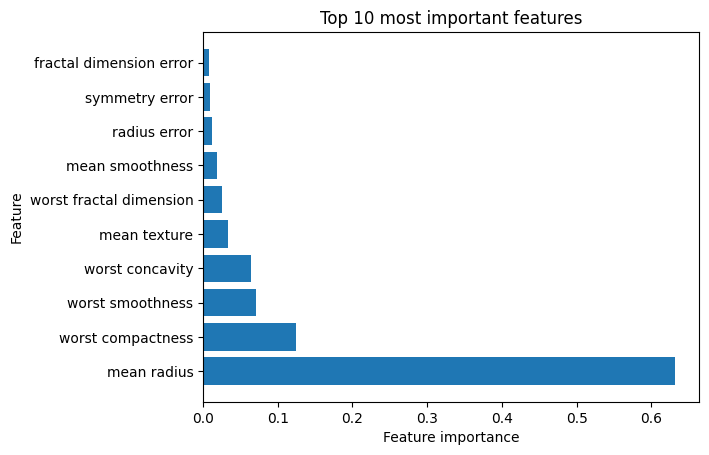

In [150]:
# Checking the feature importance for the first decision tree
import numpy as np
importances = dt_clf_sampleSplit5.feature_importances_

# # Sort the features by importance score in descending order
# indices = np.argsort(importances)[::-1]

# Sort the feature importances in descending order and get the indices of the top 10
sorted_indices = np.argsort(importances)[::-1][:10]

# Create a horizontal bar plot of the top 10 features and their importances
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), df_feature_dropped.columns[sorted_indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Top 10 most important features')
plt.show()


In reference to the above cell:
* feature importance of the third decision tree is calculated.
* The highest three features are mean radius, worst compactness, and worst smoothness, having high deterministic relationship with the tumour type.
* The highest the highest three features are the same as the first model.

In [22]:
# Train a fourth decision tree classifier with min_samples_leaf=5
dt_clf_sampleLeaf5 = DecisionTreeClassifier(min_samples_leaf=5, random_state=123)
dt_clf_sampleLeaf5.fit(X_train, y_train)

# Perform predictions on the training set and the test set
y_train_pred_sampleLeaf5 = dt_clf_sampleLeaf5.predict(X_train)
y_test_pred_sampleLeaf5 = dt_clf_sampleLeaf5.predict(X_test)

# Compare the accuracy scores for the two sets
train_accuracy_sampleLeaf5 = accuracy_score(y_train, y_train_pred_sampleLeaf5)
test_accuracy_sampleLeaf5 = accuracy_score(y_test, y_test_pred_sampleLeaf5)
tree_depth_sampleLeaf5 = dt_clf_sampleLeaf5.get_depth()

print("Training set accuracy:", train_accuracy_sampleLeaf5)
print("Test set accuracy:", test_accuracy_sampleLeaf5)
print("The depth of the tree is:", tree_depth_sampleLeaf5)

Training set accuracy: 0.9772256728778468
Test set accuracy: 0.8837209302325582
The depth of the tree is: 6


In referece to the fourth decision tree above:
* only hyperparameter min_samples_leaf=5 is set, so that the minimal sample at leaf nodes need to be 5.
* The accuracy of the training set is 97.7%.
* The accuracy of the test set is 88.4%.
* Comparing with the previous decision models, the training set performance is better. but the test set accuracy is slightly worse.
* The depth of the tree is 6. It means there are some very complex splits happening here, overfitting the training data.
* There is a not small gap between the accuracy of training and test set.
* If we try cross-validation, we will see that this model still has not ideal generalisation capability. 

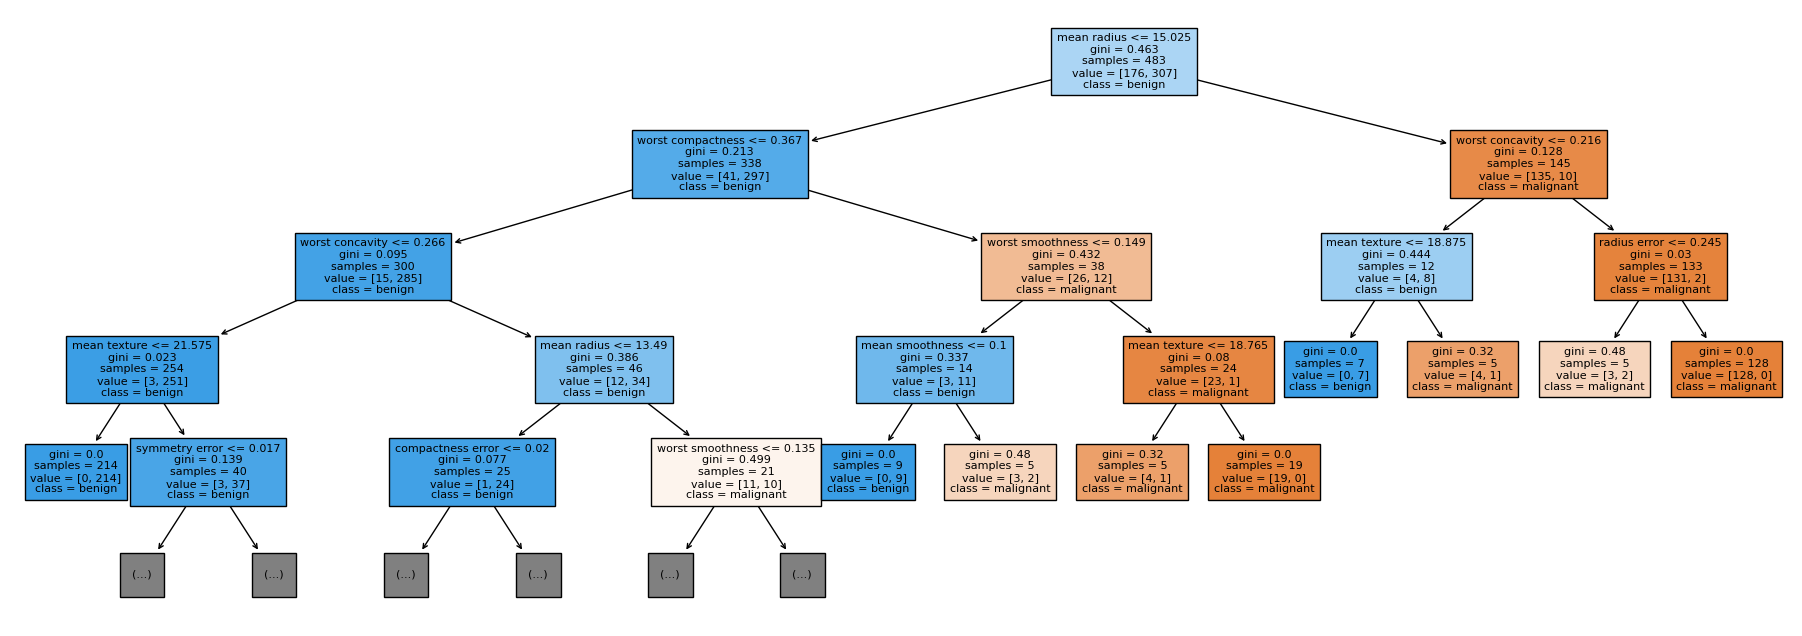

In [21]:
# Display the decision tree built from the training process (limited to max_depth=3)
plt.figure(figsize=(23, 8))
plot_tree(dt_clf_sampleLeaf5, max_depth=4, filled=True, feature_names=df_feature_dropped.columns, class_names=target_names,fontsize=8)
plt.show()

In reference to the plot above:
* plot_tree function is used here, plotting the first 4 depths of the tree.
* Looking at the gini value at different depth, we can see that some of the gini values are still quite high at 4th depth.
* The model will have to generate to the 6th depth to have the best accuracy on the training set, overfitting the feature space.
* The criteria rule of the first splits to the 4th depth is very similar to the previous three models.

All the models trained so far have overfitting issues to different extend. Decision trees are prone to overfitting when they grow without constraints, as they can develop intricate structures that adhere too closely to the training data. Overfitting occurs in this case because the decision tree algorithm is eager and continually divides the data to reduce impurity at every node. Using a single hyperparameter might not provide sufficient control over the tree's expansion, allowing it to still form overly complex structures. As a result, the model excels in handling training data but struggles with new, unseen data due to its restricted capacity for generalization.

Below, we will use grid search and cross validation to find the better combination of hyperparamters. 

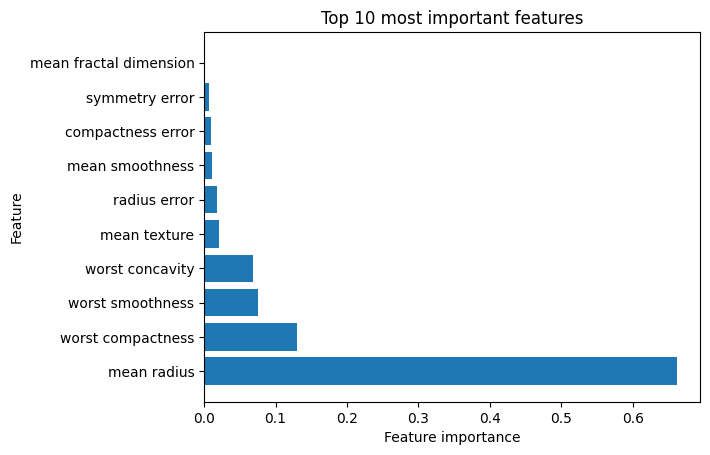

In [153]:
# Checking the feature importance for the first decision tree
import numpy as np
importances = dt_clf_sampleLeaf5.feature_importances_

# # Sort the features by importance score in descending order
# indices = np.argsort(importances)[::-1]

# Sort the feature importances in descending order and get the indices of the top 10
sorted_indices = np.argsort(importances)[::-1][:10]

# Create a horizontal bar plot of the top 10 features and their importances
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), df_feature_dropped.columns[sorted_indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Top 10 most important features')
plt.show()


In reference to the above cell:
* feature importance of the third decision tree is calculated.
* The highest three features are mean radius, worst compactness, and worst smoothness, having high deterministic relationship with the tumour type.
* The highest the highest three features are the same as the first model.

In [44]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid_dt = {
    'max_depth': list(range(1, 11)) + [None],
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11)),
}

# Perform grid search with 3-fold cross-validation
grid_search_DT = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid_dt, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_DT.fit(X_train, y_train)

# Report the best combination of hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search_DT.best_params_)
print("Best score:", grid_search_DT.best_score_)

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.9296066252587991


In reference to the cell above:
* Grid search is performed for the decision tree, for the three hyperparameters: max_depth, min_samples_split, and min_samples_leaf
* The best hyperparameter found is {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
* This is basically the same as the second trained model, having max_depth=3
* The cross validation score of the best model is 0.9296, indicating a good performance. 

In [30]:
best_params = grid_search_DT.best_params_

best_dt = DecisionTreeClassifier(**best_params, random_state=123)
best_dt.fit(X_train, y_train)

train_accuracy = accuracy_score(y_train, best_dt.predict(X_train))
test_accuracy = accuracy_score(y_test, best_dt.predict(X_test))

print(f"Training accuracy: {train_accuracy:.2f}")
print(f"Testing accuracy: {test_accuracy:.2f}")

tree_depth = best_dt.get_depth()
print(f"Depth of the tree: {tree_depth}")

Training accuracy: 0.96
Testing accuracy: 0.88
Depth of the tree: 3


In reference to the cell above:
* Using the result of the grid search, the best decision tree model is trained.
* As discussed previously, the best decision tree model is the same as the second model trained before (with only max_depth=3).
* And as can be seen, the accuracy on training the testing set is the same as the previously trained second model as well. 
* It means that for this dataset, max_depth is one of the better hyperparameter for restrict the decision tree model.
* Same as discussed before, there is still a not small gap between the accuracy of the training and testing set.
* For more discussion, please referred to the previous part.

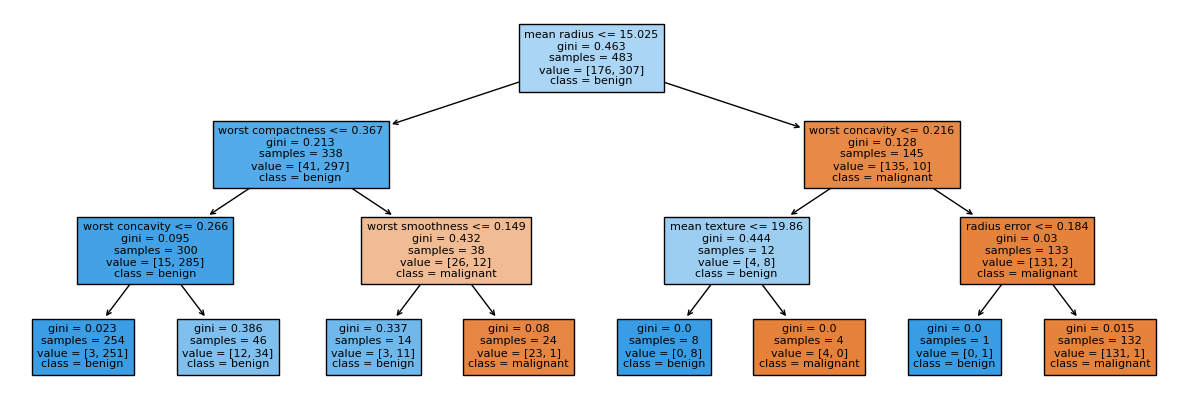

In [32]:
plt.figure(figsize=(15, 5))
plot_tree(best_dt, filled=True, feature_names=df_feature_dropped.columns, class_names=target_names,fontsize=8)
plt.show()

In reference to the cell above:
* the best decision tree is plotted. It is the same as the previous trained second model using only max_depth=3.
* for more discussion of the tree plot, please refer to the previous parts. 

The decision tree is a binary classifier to identify if a tumour in breast is maligmant or benign. 

More plots will be used below to assess the performance of the binary classifier and how the performance means in terms of clinical screening of breast cancer.

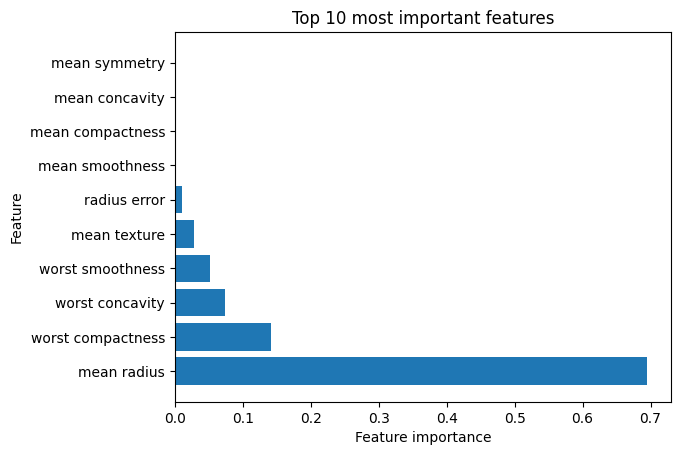

In [154]:
# Checking the feature importance for the first decision tree
import numpy as np
importances = best_dt.feature_importances_

# # Sort the features by importance score in descending order
# indices = np.argsort(importances)[::-1]

# Sort the feature importances in descending order and get the indices of the top 10
sorted_indices = np.argsort(importances)[::-1][:10]

# Create a horizontal bar plot of the top 10 features and their importances
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), df_feature_dropped.columns[sorted_indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Top 10 most important features')
plt.show()


In reference to the cell above:
* the best decision tree feature importance is plotted. It is the same as the previous trained second model using only max_depth=3.
* for more discussion of the tree plot, please refer to the previous parts. 

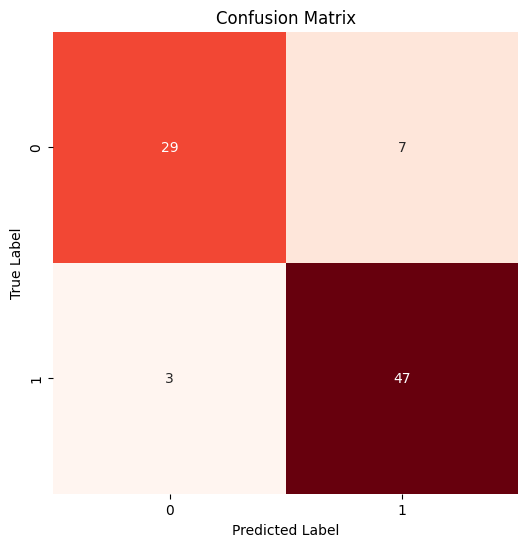

In [109]:
# Computing and plotting the confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = grid_search_DT.best_estimator_.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In reference to the cell above:
* the confusion matrix is plotted.
* 0 represents Maligant tumour and 1 means Benign tumour.
* The X axis is the predicted label and the Y axis is the true labels.
* As can be seen from the plot, there are 29 true negatives, 7 false positives, 3 false negatives and 47 true positives.
* More of the false results are benign tumours falsely identified as maligmant. It means that there is high sensitivity (recall) (Sensitivity = True Positives / (True Positives + False Negatives)), trading off from a lower specificity (Specificity = True Negatives / (True Negatives + False Positives)).
* It is good in a sense that we would like to find all the malignant tumours as much as possible to make early medical intervention. Further biopsy tests can be performed to confirm the predicted positives. 

In [106]:
# creating a feature space base on with linespace
import numpy as np
def create_feature_space(arr, num_points):
    # Define the start and end points for each feature
    start_points = np.min(arr, axis=0) + 0.2
    end_points = np.max(arr, axis=0) - 0.2

    # Create an empty array to store the linspace for each feature
    new_feature_space = np.empty((len(X_train[1]), num_points))

    # Generate the linspace for each feature
    for i in range(len(X_train[1])):
        new_feature_space[i] = np.linspace(start_points[i], end_points[i], num_points)

    # Transpose the array to have the linspace in columns instead of rows
    new_feature_space = new_feature_space.T

new_feature_space = create_feature_space(X_train,100)

The precision vs. recall curve 

In [107]:
# Define function to plot Precision, Recall vs, threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # Get the recall value where precision is above 0.9
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
    # Get threshold valie where precision is above 0.9
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=10) 
    plt.xlabel("Threshold", fontsize=10)       
    plt.grid(True)                              
    plt.axis([0, 1, 0, 1.1])             
    #plot vertical dash line from precision curve where precision is 0.9
    plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  

    #plot horizotal dash line from precision curve where precision is 0.9
    plt.plot([-1, threshold_90_precision], [0.9, 0.9], "r:")     

    #plot horisontal line from recall curve where precision is 0.9
    plt.plot([-1, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")

    #plot dot on precision curve where precision is 0.9
    plt.plot([threshold_90_precision], [0.9], "ro")         

    #plot dot on recall curve where precision is 0.9
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")   

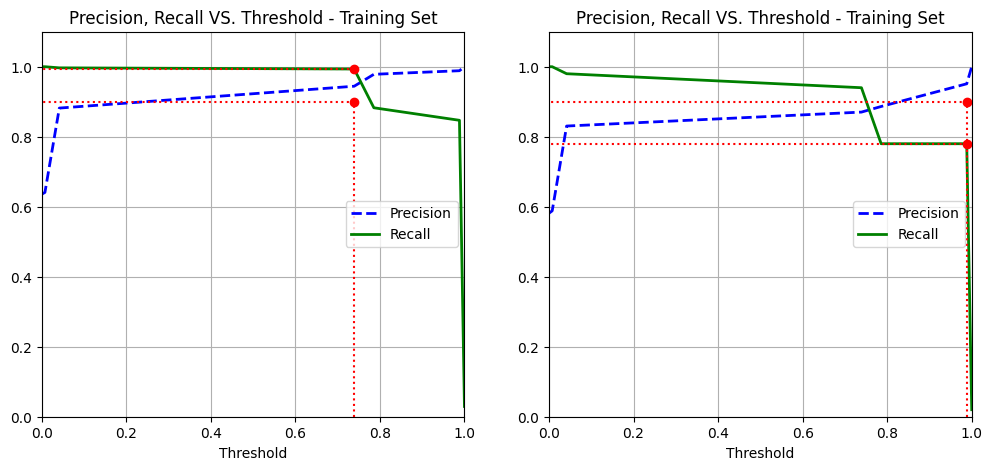

In [108]:
from sklearn.metrics import precision_recall_curve
import numpy as np
# Calculate precision and recall curve
y_train_prob_pred = best_dt.predict_proba(X_train)[:, 1]
y_test_prob_pred = best_dt.predict_proba(X_test)[:, 1]

precisions_train, recalls_train, thresholds_train = precision_recall_curve(y_train, y_train_prob_pred)
precisions_test, recalls_test, thresholds_test = precision_recall_curve(y_test, y_test_prob_pred)

plt.figure(figsize=(12, 5))       

plt.subplot(1,2,1)
plt.title('Precision, Recall VS. Threshold - Training Set')
plot_precision_recall_vs_threshold(precisions_train, recalls_train, thresholds_train)

plt.subplot(1,2,2)
plt.title('Precision, Recall VS. Threshold - Training Set')
plot_precision_recall_vs_threshold(precisions_test, recalls_test, thresholds_test)

plt.show()

In [96]:
# Define function to plot Precision VS. Recall 
def plot_precision_vs_recall(precisions, recalls,thresholds):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel("Recall", fontsize=10)
    plt.ylabel("Precision", fontsize=10)
    plt.axis([0, 1.05, 0, 1.05])
    # Get the recall value where precision is above 0.9
    recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

    #plot where 90% precision is
    plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
    plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
    plt.plot([recall_90_precision], [0.9], "ro", label = '90% Precision Threshold: ' + str(round(thresholds[np.argmax(precisions >= 0.90)],2)))

    plt.legend(loc='lower left')
    plt.grid(True)

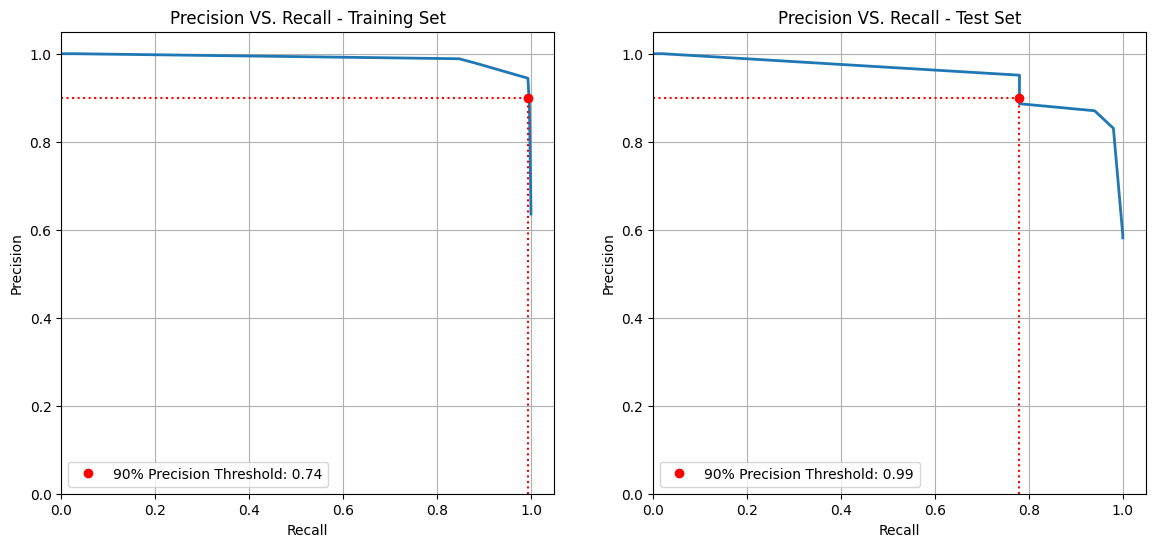

In [97]:
# Plot precision against recall for both training and testing set
fig = plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title('Precision VS. Recall - Training Set')
plot_precision_vs_recall(precisions_train, recalls_train, thresholds_train)

plt.subplot(1,2,2)
plt.title('Precision VS. Recall - Test Set')
plot_precision_vs_recall(precisions_test, recalls_test, thresholds_test)

In [101]:
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2, label=None)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([-0.1, 1, 0, 1.1])                                    
    plt.xlabel('False Positive Rate (Fall-Out/1-Specificity)', fontsize=12) 
    plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12) 
    plt.grid(True)  

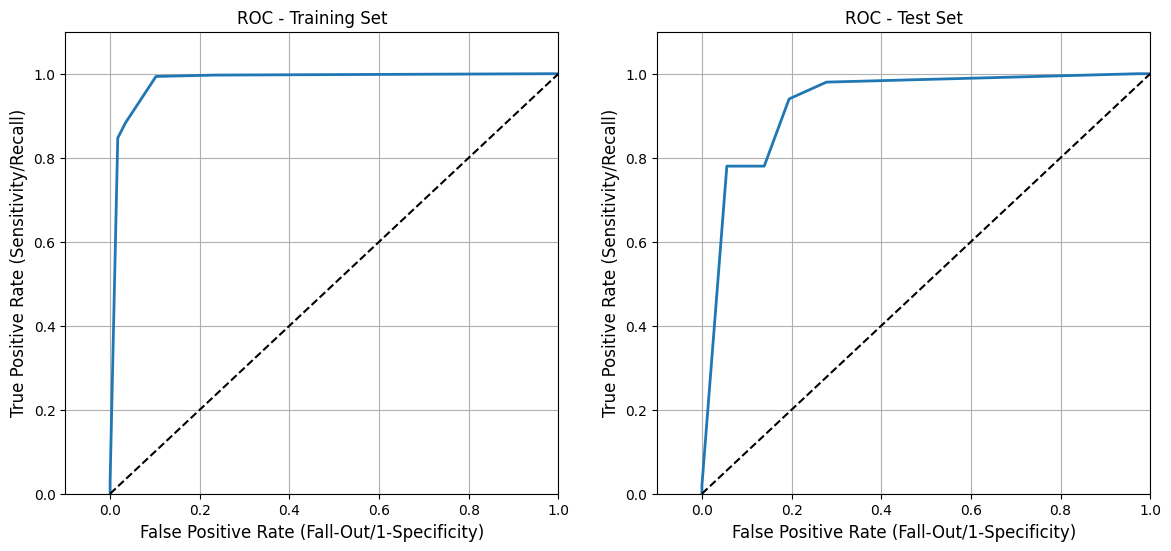

In [102]:
from sklearn.metrics import roc_curve

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_prob_pred)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob_pred)

fig = plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.title('ROC - Training Set')
plot_roc(fpr_train, tpr_train)

plt.subplot(1,2,2)
plt.title('ROC - Test Set')
plot_roc(fpr_test, tpr_test)

# Section 2: Concrete Slump Test <br>
The Concrete Slump Test dataset pertains to assessing the workability and consistency of fresh concrete through the slump test. This test evaluates how easily concrete can be placed, compacted, and finished without compromising homogeneity. The dataset comprises input features that represent concrete mix components, including cement, water, fine and coarse aggregates, and various admixtures. It also includes three output variables: slump, flow, and 28-day compressive strength. Utilizing this dataset, machine learning models can be developed to predict concrete strength and workability based on its composition. This enables engineers and construction professionals to optimize concrete mixes for specific use cases, ensuring an optimal balance of workability, strength, and durability.

### Part 1: Loading and prepare the data
* Load the Concrete Slump Test
* Investigate the data with visualisations
* Scale the feature space
* prepare the data for training the model

In [64]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data"
df_slump = pd.read_csv(url)

In [65]:
df_slump.head()

No  Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  \
0   1   273.0   82.0    105.0  210.0   9.0         904.0       680.0   
1   2   163.0  149.0    191.0  180.0  12.0         843.0       746.0   
2   3   162.0  148.0    191.0  179.0  16.0         840.0       743.0   
3   4   162.0  148.0    190.0  179.0  19.0         838.0       741.0   
4   5   154.0  112.0    144.0  220.0  10.0         923.0       658.0   

   SLUMP(cm)  FLOW(cm)  Compressive Strength (28-day)(Mpa)  
0       23.0      62.0                               34.99  
1        0.0      20.0                               41.14  
2        1.0      20.0                               41.81  
3        3.0      21.5                               42.08  
4       20.0      64.0                               26.82

As can be seen:
* the No column is irrelavant and needs to be dropped.
* All features are numeric
* there are 7 features and 3 targets

In [111]:
# To see the total number of missing values in the entire DataFrame
total_missing_values = df_slump.isna().sum().sum()
print(f"\nTotal missing values in DataFrame: {total_missing_values}")


Total missing values in DataFrame: 0


In [112]:
# define a function to drop columns
def drop_columns(df, li_columns):
    df_dropped = df.drop(columns=li_columns)
    return df_dropped

In [69]:
# Drop the 'No' Column and the other two targets that is not needed
li_columns = ['FLOW(cm)', 'SLUMP(cm)','No']
df_output_dropped = drop_columns(df_slump,li_columns)

In [113]:
# double check the dataset
df_output_dropped.head()

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  \
0   273.0   82.0    105.0  210.0   9.0         904.0       680.0   
1   163.0  149.0    191.0  180.0  12.0         843.0       746.0   
2   162.0  148.0    191.0  179.0  16.0         840.0       743.0   
3   162.0  148.0    190.0  179.0  19.0         838.0       741.0   
4   154.0  112.0    144.0  220.0  10.0         923.0       658.0   

   Compressive Strength (28-day)(Mpa)  
0                               34.99  
1                               41.14  
2                               41.81  
3                               42.08  
4                               26.82

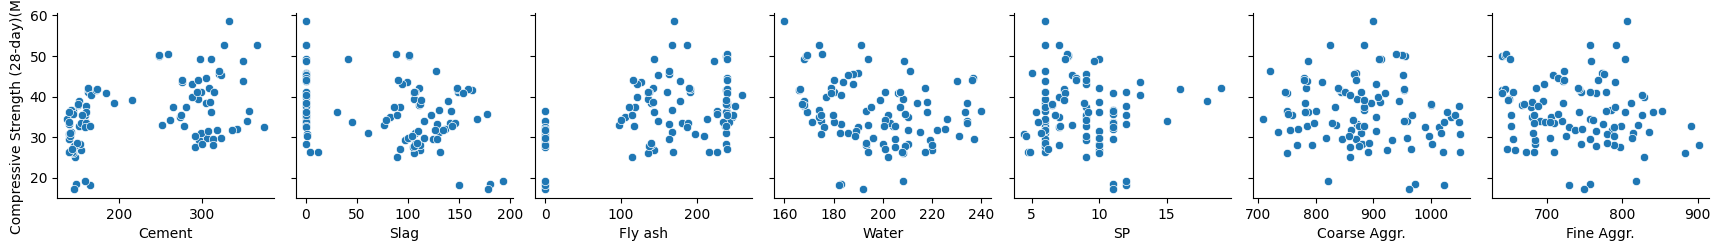

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the data using pair plots and correlation matrix
feature_columns = df_output_dropped.columns[:-1]  # Exclude the No column and output variables
sns.pairplot(df_output_dropped, x_vars=feature_columns, y_vars=['Compressive Strength (28-day)(Mpa)'])
plt.show()

In referece to the plot above;
* plotting each feature vs target values to see if any specific feature is more correlated to the target -- higher importance.
* As can be seen, some features like cement have slightly higher correlation to target values than others. 

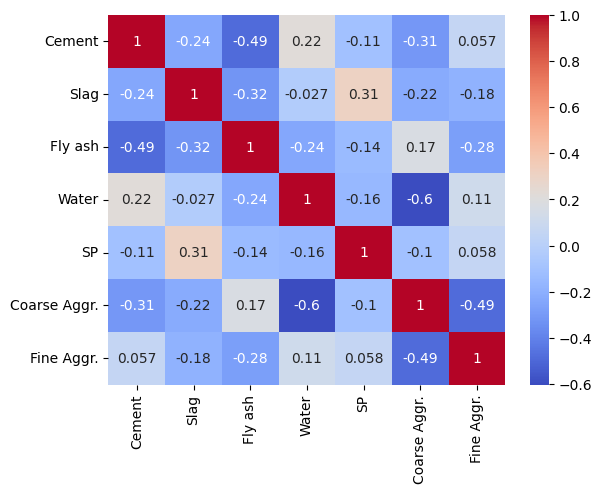

In [116]:
# calculate the correlation matrix and plot heatmap
correlation_matrix_slump = df_output_dropped[feature_columns].corr()
sns.heatmap(correlation_matrix_slump, annot=True, cmap='coolwarm')
plt.show()

As can be seen, most of the features are not very correlated with each other. However, for completion of data cleaning process, and in case the data updates in the future, we will run the function defined in part 1 to drop correlated features.

In [124]:
df_cleaned = drop_corr_features(0.9,correlation_matrix_slump,df_output_dropped[feature_columns])

0 features is dropped: set()


In [125]:
df_cleaned[df_output_dropped.columns[-1]] = df_output_dropped[df_output_dropped.columns[-1]]

In [126]:
df_cleaned.head()

Cement   Slag  Fly ash  Water    SP  Coarse Aggr.  Fine Aggr.  \
0   273.0   82.0    105.0  210.0   9.0         904.0       680.0   
1   163.0  149.0    191.0  180.0  12.0         843.0       746.0   
2   162.0  148.0    191.0  179.0  16.0         840.0       743.0   
3   162.0  148.0    190.0  179.0  19.0         838.0       741.0   
4   154.0  112.0    144.0  220.0  10.0         923.0       658.0   

   Compressive Strength (28-day)(Mpa)  
0                               34.99  
1                               41.14  
2                               41.81  
3                               42.08  
4                               26.82

In [128]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the dataset into training and test sets (80/20)
X = df_cleaned.drop(columns=['Compressive Strength (28-day)(Mpa)']).values
y = df_cleaned['Compressive Strength (28-day)(Mpa)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [129]:
# scale the feature space using standard scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Part 2: Training the voting regressor
* Using 3 base estimators with default hyperparameters: (i) a linear SVM regressor, (ii) a linear regressor (using the LinearRegression class), and (iii) a Stochastic Gradient Descent regressor
* Individually tune a few hyperparameters for each of these base estimators. You can use 3-fold
cross-validation with Grid-Search to select the best hyperparameters

In [130]:
# training a voting regressor using (i) a linear SVM regressor, (ii) a linear regressor (using the LinearRegression class), and (iii) a Stochastic Gradient Descent regressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

# Train the base estimators
# linear_svr = LinearSVR(max_iter=30000000, random_state=123).fit(X_train, y_train)
linear_svr = SVR(kernel='linear').fit(X_train, y_train)
linear_regressor = LinearRegression().fit(X_train, y_train)
sgd_regressor = SGDRegressor(random_state=123).fit(X_train, y_train)

# Train the Voting regressor
voting_regressor = VotingRegressor(
    estimators=[('linear_svr', linear_svr),
                ('linear_regressor', linear_regressor),
                ('sgd_regressor', sgd_regressor)]
).fit(X_train, y_train)

# Calculate the RMSE for each model
models = [linear_svr, linear_regressor, sgd_regressor, voting_regressor]
model_names = ['Linear SVM Regressor', 'Linear Regressor', 'SGD Regressor', 'Voting Regressor']
predictions = [model.predict(X_test) for model in models]
rmse = [np.sqrt(mean_squared_error(y_test, pred)) for pred in predictions]

for name, rmse_value in zip(model_names, rmse):
    print(f"{name} RMSE: {rmse_value}")

Linear SVM Regressor RMSE: 2.9104631777059002
Linear Regressor RMSE: 3.2938784151981335
SGD Regressor RMSE: 3.1844361485532273
Voting Regressor RMSE: 3.123169711647982


In reference to the cell above:
* three base estimators using default hyperparameters are trained. 
* a voting regressor using the three base estimator is trained.
* The performance of the three base estimators: SVR has the smallest RMSE -- 2.91, SGD is the second -- 3.18 and the linear regressor has the biggest RMSE -- 3.29
* In general, the RMSE for the three base estimators are similar to each other.
* The RMSE for the voting regressor using the three base estimators is 3.12. It is better than two of the base estimators (linear regression and SGD), but worse than the best base estimator (SVR).

The performance of the voting regressor can be due to:
* __Variety in Models__: The Voting Regressor tends to perform better when the base estimators have distinct characteristics, as well as varying strengths and limitations. In this specific instance, the linear SVM regressor might already exhibit strong performance, while the other models do not provide substantial additional benefits when combined.
* __Model Performance__: The effectiveness of a Voting Regressor is influenced by the capabilities of its base estimators. If the linear SVM regressor demonstrates superior performance compared to the other base estimators, it may be an indication that the linear SVM regressor is already well-suited for the problem at hand, and the inclusion of the other models does not provide significant enhancement to the overall performance.
* __Hyperparameters__: Relying on the default hyperparameters for the base estimators might not always yield optimal performance. In this particular case, the linear SVM regressor's default hyperparameters could be well-suited for the problem at hand, enabling it to outperform the Voting Regressor.

<br><br>
__Voting Regressor__ <br>
A Voting Regressor is an ensemble learning technique that merges multiple regression models to produce more precise and stable predictions. It operates by independently training several base regressors on an identical dataset and then, during the prediction stage, it consolidates their individual predictions through averaging. By integrating the predictions from various models, the Voting Regressor frequently attains superior performance compared to any single base model. This is attributed to leveraging each model's strengths while mitigating their weaknesses, thus diminishing the overall influence of a single model's limitations or biases.

__Linear SVR__ <br>
A linear SVM (Support Vector Machine) regressor, utilizing default parameters, is a machine learning technique designed for solving regression problems. By employing a linear kernel function, it establishes a linear decision boundary within the feature space, aiming to minimize prediction errors for the target variable. While SVM is originally conceived for classification, it can be adapted for regression tasks using the ε-insensitive loss function. This function strives to maximize the margin around the regression function while allowing for errors within a specific threshold (ε). The default settings for a linear SVM regressor, such as those found in scikit-learn's SVR class, comprise a linear kernel, a regularization parameter C set to 1.0, and a tolerance value ε of 0.1. These defaults offer a starting point for model performance, which can be further optimized by tuning the parameters based on the dataset at hand.

__Linear regression__
A linear regressor with default parameters is a straightforward machine learning model that forecasts a target variable by creating a linear connection between input features and the target variable. The model presumes that the target variable can be represented as a linear combination of input features, each multiplied by a specific weight or coefficient. During training, the model determines these coefficients using a standard loss function (usually mean squared error) and optimization method (such as ordinary least squares). This elementary linear regression model does not incorporate any regularization methods, but its simplicity and ease of implementation make it a widely used starting point for various regression tasks.

__Stochastic Gradient Descent regressor__
An SGD regressor with default settings is a linear regression model that leverages Stochastic Gradient Descent for loss function minimization. It iteratively updates model parameters using random data subsets, enabling quicker convergence and effective handling of large datasets. Default parameters consist of a constant learning rate, no regularization, and a 1000 iteration maximum. Feature scaling sensitivity necessitates input feature standardization before training.

The below three cells are visualisations for data points for the whole test set. The ground truth vs prediction values are plotted together to be compared with each other.

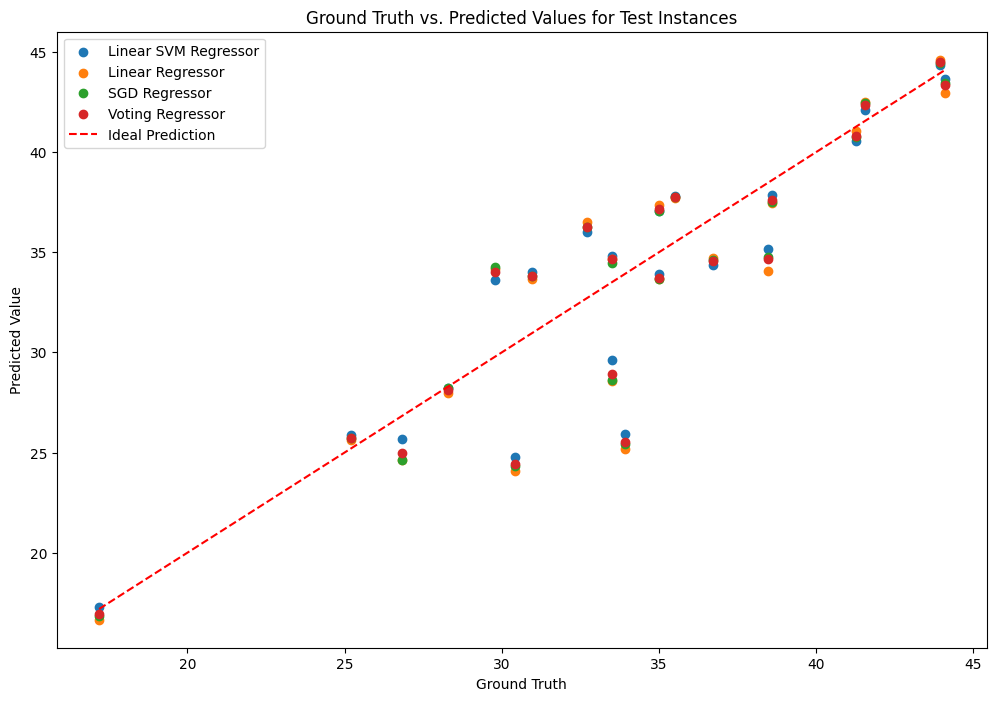

In [37]:
# Illustrate the predicted values vs. the ground truth values for all test instances
plt.figure(figsize=(12, 8))
for i, (name, pred) in enumerate(zip(model_names, predictions)):
    plt.scatter(y_test, pred, label=name)

# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('Ground Truth')
plt.ylabel('Predicted Value')
plt.legend()
plt.title('Ground Truth vs. Predicted Values for Test Instances')
plt.show()

In reference to the cell above:
* The x axis is the ground truth
* The y axis is the predicted values
* The red dotted line is the ideal prediction, if the predicted value is exactly the same as the ground truth
* The predicted from each one of the models is plotted on the same plot. The closer the prediction point to the red dotted line, the better prediction for that test instance.

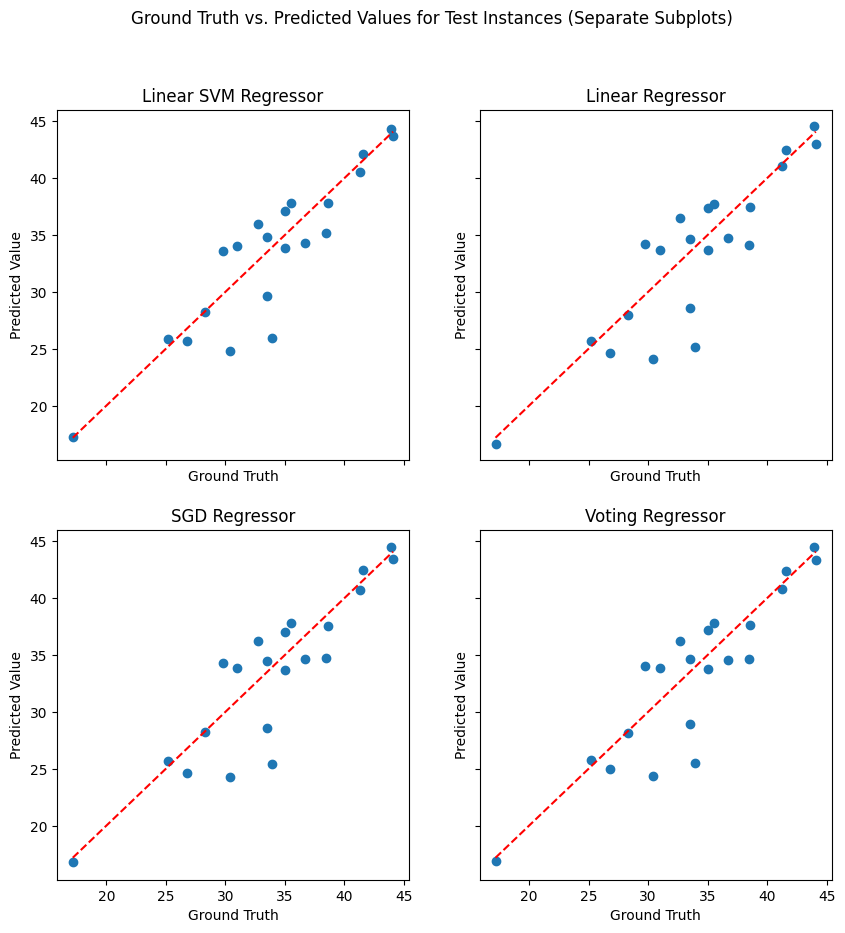

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.ravel()

for i, (name, pred) in enumerate(zip(model_names, predictions)):
    axes[i].scatter(y_test, pred)
    axes[i].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[i].set_title(name)
    axes[i].set_xlabel('Ground Truth')
    axes[i].set_ylabel('Predicted Value')

plt.suptitle('Ground Truth vs. Predicted Values for Test Instances (Separate Subplots)')
plt.show()

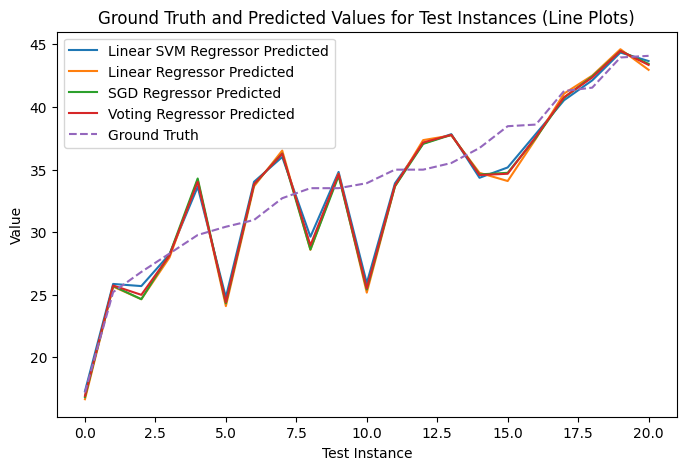

In [39]:
plt.figure(figsize=(8, 5))

for i, (name, pred) in enumerate(zip(model_names, predictions)):
    sorted_indices = np.argsort(y_test)
    plt.plot(pred[sorted_indices], label=f"{name} Predicted", linestyle='-')

plt.plot(y_test[sorted_indices], label=f"Ground Truth", linestyle='--')

plt.xlabel('Test Instance')
plt.ylabel('Value')
plt.legend()
plt.title('Ground Truth and Predicted Values for Test Instances (Line Plots)')
plt.show()


In [40]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grids
linear_svr_params = {
    'epsilon': [0.01, 0.1, 1],
    'C': [0.1, 1, 10],
}
linear_regressor_params = {
    'fit_intercept': [True, False],
    # 'normalize': [True, False],
}
sgd_regressor_params = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'max_iter': [1000, 5000, 10000],
    'early_stopping': [True, False],
}

# Perform Grid-Search with cross-validation for each base estimator
# linear_svr_gs = GridSearchCV(LinearSVR(max_iter=30000000, random_state=123), linear_svr_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
linear_svr_gs = GridSearchCV(SVR(kernel='linear'), linear_svr_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
linear_regressor_gs = GridSearchCV(LinearRegression(), linear_regressor_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
sgd_regressor_gs = GridSearchCV(SGDRegressor(random_state=123), sgd_regressor_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

gs_results = [gs.fit(X_train, y_train) for gs in [linear_svr_gs, linear_regressor_gs, sgd_regressor_gs]]

# Train the base estimators with the best hyperparameters
linear_svr_tuned = linear_svr_gs.best_estimator_
linear_regressor_tuned = linear_regressor_gs.best_estimator_
sgd_regressor_tuned = sgd_regressor_gs.best_estimator_

# Train the Voting regressor with tuned base estimators
voting_regressor_tuned = VotingRegressor(
    estimators=[('linear_svr', linear_svr_tuned),
                ('linear_regressor', linear_regressor_tuned),
                ('sgd_regressor', sgd_regressor_tuned)]
).fit(X_train, y_train)

# Calculate the RMSE for each tuned model
tuned_models = [linear_svr_tuned, linear_regressor_tuned, sgd_regressor_tuned, voting_regressor_tuned]
tuned_predictions = [model.predict(X_test) for model in tuned_models]
tuned_rmse = [np.sqrt(mean_squared_error(y_test, pred)) for pred in tuned_predictions]

for name, rmse_value in zip(model_names, tuned_rmse):
    print(f"{name} (Tuned) RMSE: {rmse_value}")

Linear SVM Regressor (Tuned) RMSE: 3.5007749804366406
Linear Regressor (Tuned) RMSE: 3.2938784151981335
SGD Regressor (Tuned) RMSE: 3.177464384934414
Voting Regressor (Tuned) RMSE: 3.3149385870358694


# Section 3: Abalone dataset

In [41]:
import pandas as pd
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
column_names = ["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]

data = pd.read_csv(url, header=None, names=column_names)
print(data.head())

  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  


In [42]:
print(data.isnull().sum())  # Check for missing values
print(data.describe())  # Check for any anomalies in the data

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64
            Length     Diameter       Height  Whole weight  Shucked weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera weight  Shell weight        Rings  
count     4177.000000   4177.000000  4177.000000  
me

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Separate features and target
X = data.drop(columns="Rings")
y = data["Rings"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']),
        ('cat', OneHotEncoder(), ['Sex'])
    ])

# Create a pipeline with the preprocessor
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the pipeline to the data
X_processed = pipeline.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.15, random_state=123)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

max_depths = list(range(1, 21))
train_errors, cv_errors, test_errors = [], [], []

for depth in max_depths:
    dt_regressor = DecisionTreeRegressor(max_depth=depth, random_state=123)
    
    # Compute training error
    dt_regressor.fit(X_train, y_train)
    train_error = np.mean((y_train - dt_regressor.predict(X_train)) ** 2)
    train_errors.append(train_error)
    
    # Compute cross-validation error
    cv_error = -np.mean(cross_val_score(dt_regressor, X_train, y_train, cv=3, scoring='neg_mean_squared_error'))
    cv_errors.append(cv_error)
    
    # Compute test error
    test_error = np.mean((y_test - dt_regressor.predict(X_test)) ** 2)
    test_errors.append(test_error)

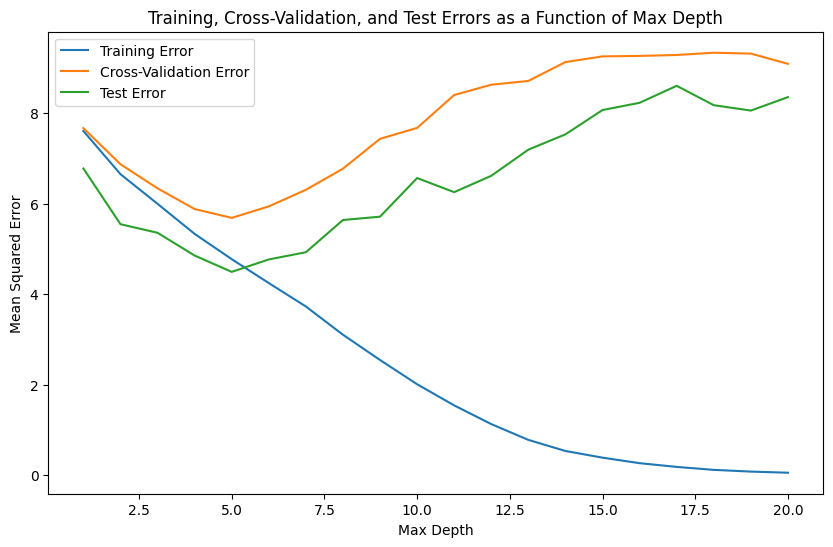

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error')
plt.plot(max_depths, cv_errors, label='Cross-Validation Error')
plt.plot(max_depths, test_errors, label='Test Error')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training, Cross-Validation, and Test Errors as a Function of Max Depth')
plt.show()

In [46]:
print('The best max_depths value is:',max_depths[cv_errors.index(min(cv_errors))])

The best max_depths value is: 5


In [47]:
min_samples_leaf_values = list(range(1, 21))
train_errors, cv_errors, test_errors = [], [], []

for min_samples_leaf in min_samples_leaf_values:
    dt_regressor = DecisionTreeRegressor(max_depth=6, min_samples_leaf=min_samples_leaf, random_state=123)
    
    # Compute training error
    dt_regressor.fit(X_train, y_train)
    train_error = np.mean((y_train - dt_regressor.predict(X_train)) ** 2)
    train_errors.append(train_error)
    
    # Compute cross-validation error
    cv_error = -np.mean(cross_val_score(dt_regressor, X_train, y_train, cv=3, scoring='neg_mean_squared_error'))
    cv_errors.append(cv_error)
    
    # Compute test error
    test_error = np.mean((y_test - dt_regressor.predict(X_test)) ** 2)
    test_errors.append(test_error)


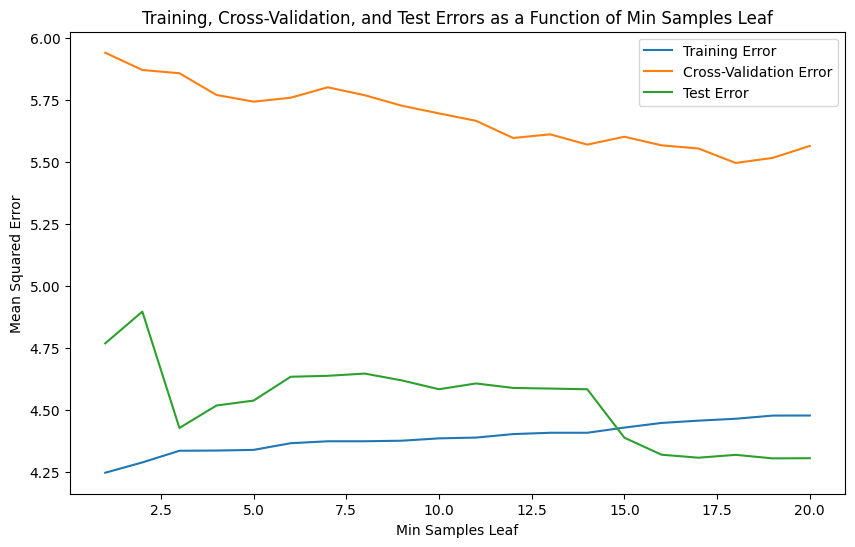

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, train_errors, label='Training Error')
plt.plot(min_samples_leaf_values, cv_errors, label='Cross-Validation Error')
plt.plot(min_samples_leaf_values, test_errors, label='Test Error')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training, Cross-Validation, and Test Errors as a Function of Min Samples Leaf')
plt.show()


In [49]:
print('The best min_samples_leaf value is:',min_samples_leaf_values[cv_errors.index(min(cv_errors))])

The best min_samples_leaf value is: 18


In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

random_forest_regressor = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=8,
    # Experiment with other hyperparameters if desired
    # max_samples=0.7,
    # max_features='sqrt',
    # bootstrap=True,
    random_state=123
)

random_forest_regressor.fit(X_train, y_train)

y_pred = random_forest_regressor.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE for the Random Forest Regressor on the test set: {rmse:.2f}")


RMSE for the Random Forest Regressor on the test set: 1.97


In [51]:
from sklearn.feature_selection import SelectFromModel

threshold = 0.05
selector = SelectFromModel(random_forest_regressor, threshold=threshold, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

feature_names=column_names[:-1]
selected_features = np.array(feature_names)[selector.get_support()]
print(f"Selected features with importance values above {threshold * 100}%:")
print(selected_features)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 10

In [ ]:
reduced_feature_indices = [feature_names.index(feature) for feature in selected_features]

X_train_reduced = X_train[:, reduced_feature_indices]
X_test_reduced = X_test[:, reduced_feature_indices]

random_forest_regressor_reduced = RandomForestRegressor(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=8,
    random_state=123
)

random_forest_regressor_reduced.fit(X_train_reduced, y_train)

y_pred_reduced = random_forest_regressor_reduced.predict(X_test_reduced)

rmse_reduced = np.sqrt(mean_squared_error(y_test, y_pred_reduced))
print(f"RMSE for the Random Forest Regressor on the reduced-dimensional test set: {rmse_reduced:.2f}")

RMSE for the Random Forest Regressor on the reduced-dimensional test set: 3.25


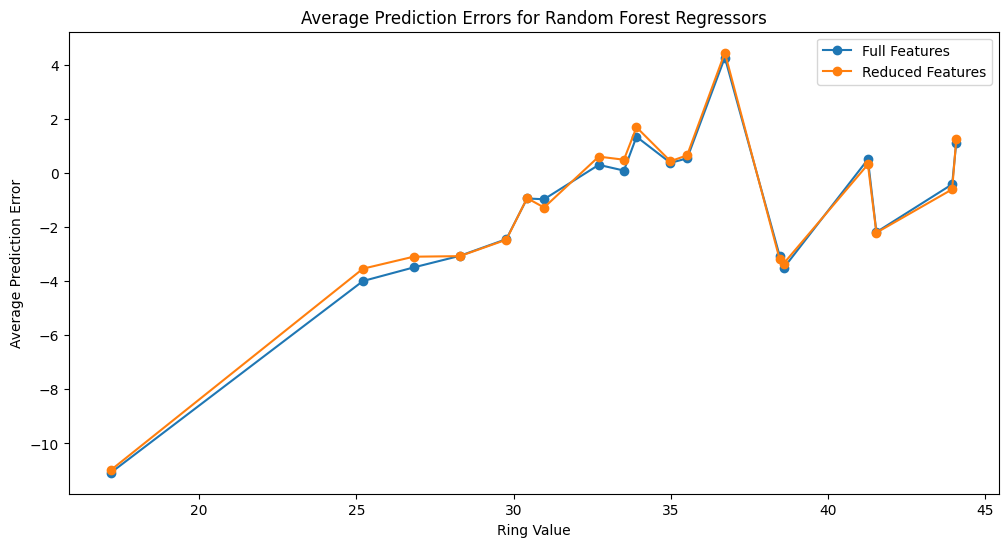

In [ ]:
errors = y_test - y_pred
errors_reduced = y_test - y_pred_reduced

unique_ring_values = np.unique(y_test)
avg_errors = [np.mean(errors[y_test == ring_value]) for ring_value in unique_ring_values]
avg_errors_reduced = [np.mean(errors_reduced[y_test == ring_value]) for ring_value in unique_ring_values]

plt.figure(figsize=(12, 6))
plt.plot(unique_ring_values, avg_errors, label='Full Features', marker='o')
plt.plot(unique_ring_values, avg_errors_reduced, label='Reduced Features', marker='o')
plt.xlabel('Ring Value')
plt.ylabel('Average Prediction Error')
plt.title('Average Prediction Errors for Random Forest Regressors')
plt.legend()
plt.show()

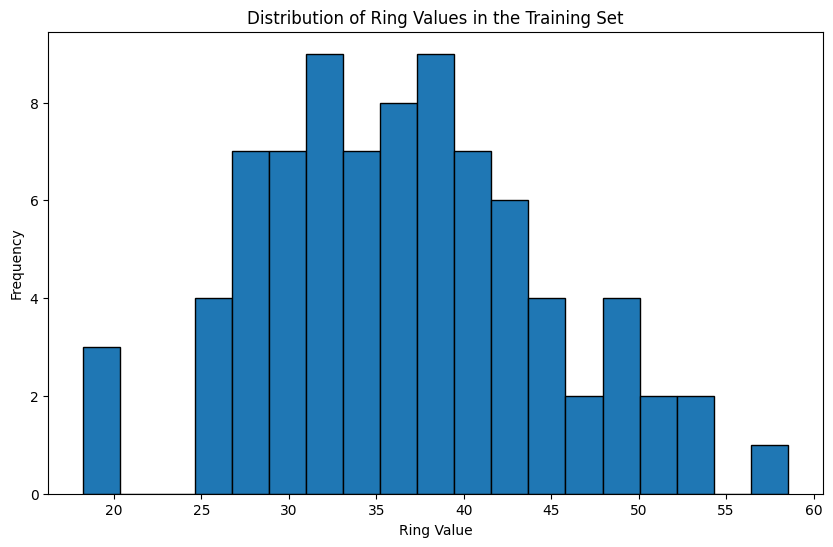

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=len(unique_ring_values), edgecolor='black')
plt.xlabel('Ring Value')
plt.ylabel('Frequency')
plt.title('Distribution of Ring Values in the Training Set')
plt.show()

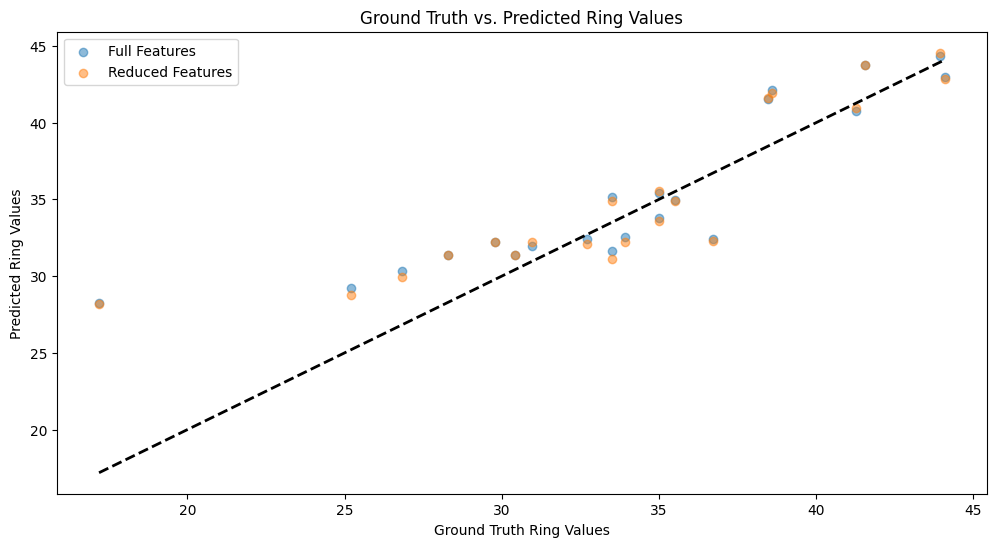

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Full Features')
plt.scatter(y_test, y_pred_reduced, alpha=0.5, label='Reduced Features')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Ground Truth Ring Values')
plt.ylabel('Predicted Ring Values')
plt.title('Ground Truth vs. Predicted Ring Values')
plt.legend()
plt.show()


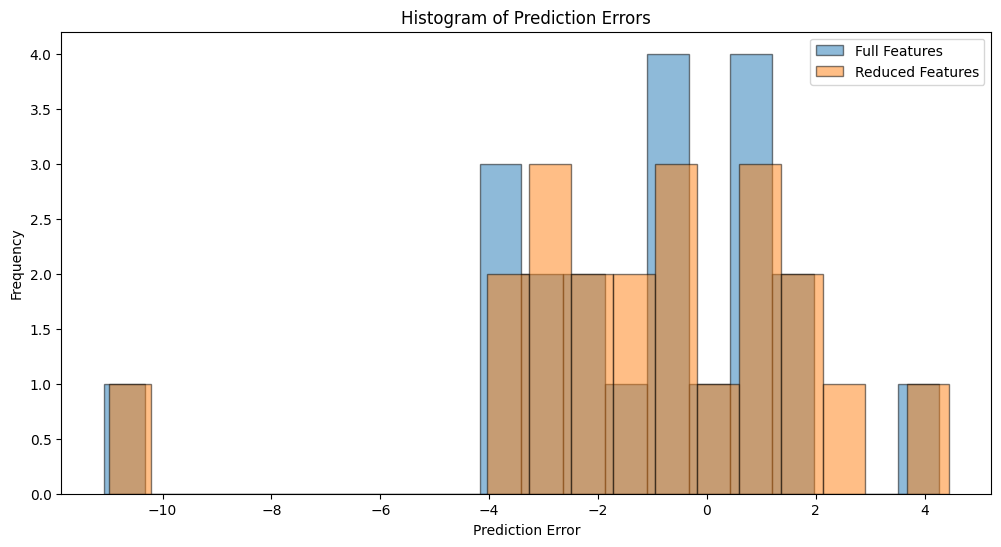

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=20, alpha=0.5, edgecolor='black', label='Full Features')
plt.hist(errors_reduced, bins=20, alpha=0.5, edgecolor='black', label='Reduced Features')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR

svm_regressor = SVR(kernel='linear', C=1)  # Choose some reasonable hyperparameter values manually for the SVM regressor

bagging_regressor = BaggingRegressor(
    estimator=svm_regressor,
    n_estimators=500,
    # Use the same common hyperparameter values as the Random Forest regressor
    max_samples=0.8,
    # max_features='sqrt',
    bootstrap=True,
    random_state=123
)

bagging_regressor.fit(X_train, y_train)

y_pred_bagging = bagging_regressor.predict(X_test)

rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
print(f"RMSE for the Bagging Regressor on the test set: {rmse_bagging:.2f}")


RMSE for the Bagging Regressor on the test set: 2.96


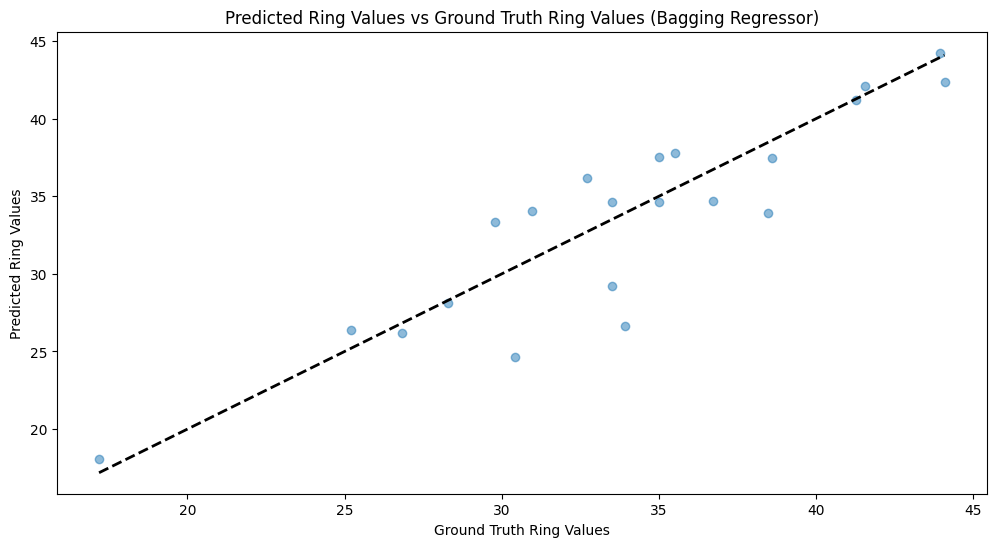

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_bagging, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Ground Truth Ring Values')
plt.ylabel('Predicted Ring Values')
plt.title('Predicted Ring Values vs Ground Truth Ring Values (Bagging Regressor)')
plt.show()
